In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd /content/gdrive/MyDrive/Data/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Data


### Importing

In [ ]:
# Essential Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from time import time
import timeit
# scikit-learn Imports
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, LeaveOneOut, KFold, train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, LogisticRegressionCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import neighbors
from sklearn.model_selection import cross_val_score, KFold, LeaveOneOut
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score
from sklearn.naive_bayes import GaussianNB

# statsmodels Imports
import statsmodels.formula.api as smf
import statsmodels.api as sm

### Data Set Up

In [ ]:
df2 = pd.read_csv('marketing_campaign_cleaned.csv', na_values='?').dropna()
print(df2.shape)
print()
print(df2.describe())
print()
df2.info()
df2.head(5)

(2216, 29)

                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2216.000000  2216.000000    2216.000000  2216.000000  2216.000000   
mean    5588.353339  1968.820397   52247.251354     0.441787     0.505415   
std     3249.376275    11.985554   25173.076661     0.536896     0.544181   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2814.750000  1959.000000   35303.000000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8421.750000  1977.000000   68522.000000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2216.000000  2216.000000  2216.000000      2216.000000   
mean     49.012635   305.091606    26.356047       166.995939   
std      28.948352   337.327920    39.793917       224.283273   
min       0.000000     0.000000   

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [ ]:
Q1 = df2['Income'].quantile(0.25)
Q3 = df2['Income'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df2_cleaned = df2[(df2['Income'] >= lower_bound) & (df2['Income'] <= upper_bound)].copy()

original_rows = df2.shape[0]
cleaned_rows = df2_cleaned.shape[0]
rows_removed = original_rows - cleaned_rows

print(f"Original number of rows: {original_rows}")
print(f"Number of rows after outlier removal: {cleaned_rows}")
print(f"Number of rows removed: {rows_removed}")
print()
median_income = df2_cleaned['Income'].median()
print(f"Median Income after outlier removal: {median_income}")

df2_cleaned.loc[:, 'Income_Category'] = df2_cleaned['Income'].apply(lambda x: 'low' if x < median_income else 'high')
display(df2_cleaned.head())

Original number of rows: 2216
Number of rows after outlier removal: 2208
Number of rows removed: 8

Median Income after outlier removal: 51301.0


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Income_Category
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,0,0,0,0,0,0,3,11,1,high
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,0,0,0,0,0,0,3,11,0,low
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,0,0,0,0,0,0,3,11,0,high
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,0,0,0,0,0,0,3,11,0,low
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,0,0,0,0,0,0,3,11,0,high


In [ ]:
X = df2_cleaned.loc[:,["MntWines","MntMeatProducts","NumWebVisitsMonth","Teenhome"]]
y = df2_cleaned.loc[:, ["Income_Category"]].values.ravel()

### Logistic Regression Classifier (LogReg)

### LogReg Full Dataset


In [ ]:
#summary of full data for LogReg
start_time = timeit.default_timer()

model = LogisticRegression(solver='liblinear')
model.fit(X, y)


y_pred_full = model.predict(X)

accuracy = accuracy_score(y, y_pred_full)
specificity = confusion_matrix(y, y_pred_full)[0, 0] / (confusion_matrix(y, y_pred_full)[0, 0] + confusion_matrix(y, y_pred_full)[0, 1])
sensitivity = confusion_matrix(y, y_pred_full)[1, 1] / (confusion_matrix(y, y_pred_full)[1, 0] + confusion_matrix(y, y_pred_full)[1, 1])
runtime = timeit.default_timer() - start_time


print(confusion_matrix(y, y_pred_full))
print(classification_report(y, y_pred_full, digits=3))
print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)


[[ 988  116]
 [  76 1028]]
              precision    recall  f1-score   support

        high      0.929     0.895     0.911      1104
         low      0.899     0.931     0.915      1104

    accuracy                          0.913      2208
   macro avg      0.914     0.913     0.913      2208
weighted avg      0.914     0.913     0.913      2208

Accuracy 0.9130434782608695
Specficity 0.894927536231884
Sensitivity 0.9311594202898551
Run time is 0.15304744800000947 seconds


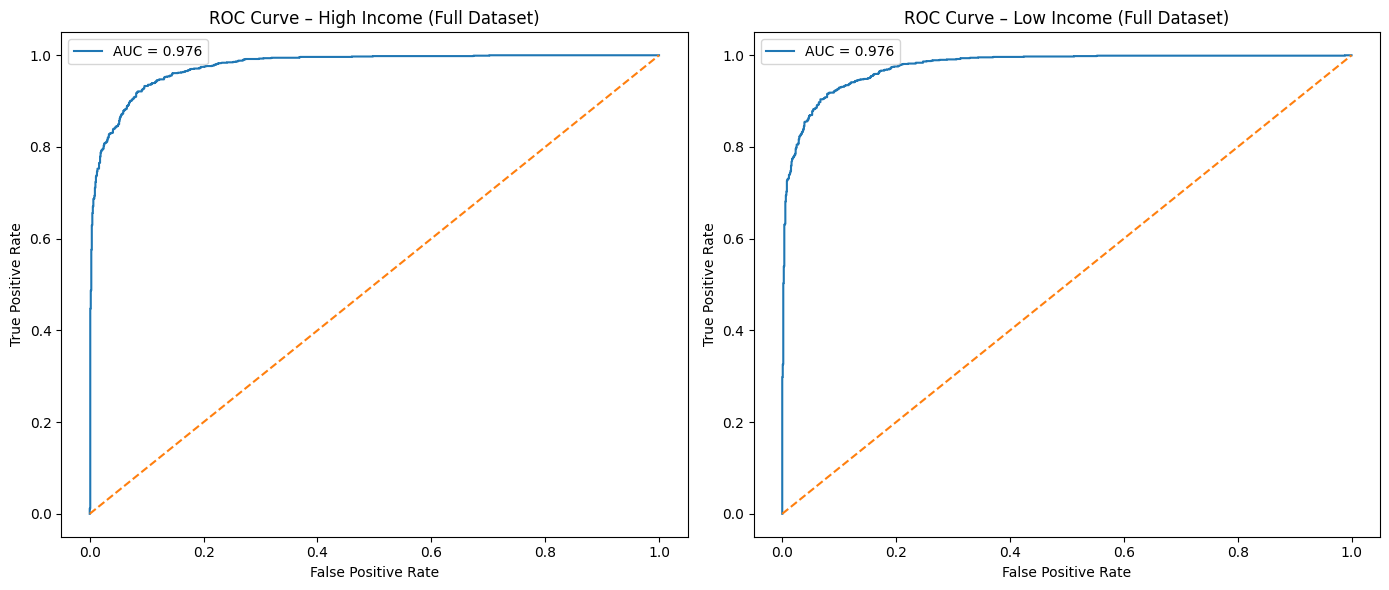

In [ ]:
#ROC curves for full data of LogReg model
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]

y_prob_high = model.predict_proba(X)[:, pos_index_high]
y_binary_high = np.where(y == 'high', 1, 0)

auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)

axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (Full Dataset)")
axes[0].legend()

y_prob_low = model.predict_proba(X)[:, neg_index_low]
y_binary_low = np.where(y == 'low', 1, 0)

auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)

axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (Full Dataset)")
axes[1].legend()

plt.tight_layout()
plt.show()

### LogReg with 50% Validation

In [ ]:
#summary of 50/50 split log reg model
start_time = timeit.default_timer()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

model = LogisticRegression(solver='liblinear')
model.fit(X_train, y_train)

y_pred_val = model.predict(X_test)

print(confusion_matrix(y_test, y_pred_val))
print(classification_report(y_test, y_pred_val, digits=3))
accuracy = accuracy_score(y_test, y_pred_val)
specificity = confusion_matrix(y_test, y_pred_val)[0, 0] / (confusion_matrix(y_test, y_pred_val)[0, 0] + confusion_matrix(y_test, y_pred_val)[0, 1])
sensitivity = confusion_matrix(y_test, y_pred_val)[1, 1] / (confusion_matrix(y_test, y_pred_val)[1, 0] + confusion_matrix(y_test, y_pred_val)[1, 1])
runtime = timeit.default_timer() - start_time

print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)

[[498  51]
 [ 37 518]]
              precision    recall  f1-score   support

        high      0.931     0.907     0.919       549
         low      0.910     0.933     0.922       555

    accuracy                          0.920      1104
   macro avg      0.921     0.920     0.920      1104
weighted avg      0.921     0.920     0.920      1104

Accuracy 0.9202898550724637
Specficity 0.907103825136612
Sensitivity 0.9333333333333333
Run time is 0.16210514999998793 seconds


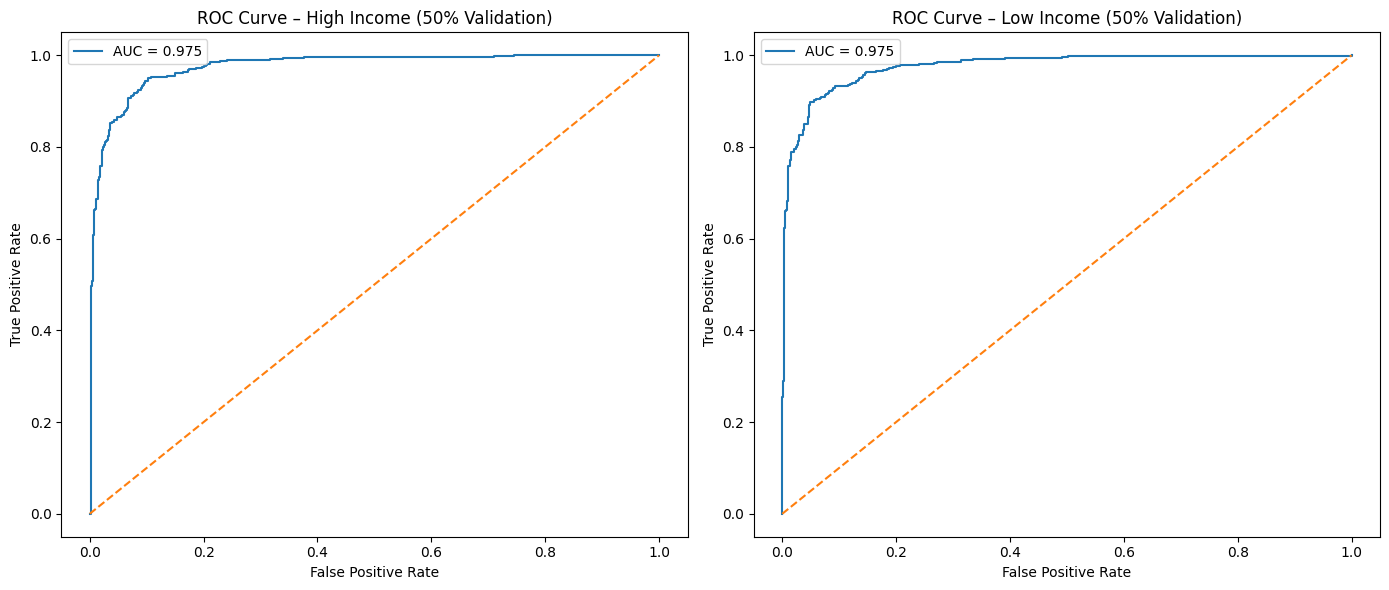

In [ ]:
#ROC curve for 50/50 split LogReg
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]

y_prob_high = model.predict_proba(X_test)[:, pos_index_high]
y_binary_high = np.where(y_test == 'high', 1, 0)

auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)

axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (50% Validation)")
axes[0].legend()

y_prob_low = model.predict_proba(X_test)[:, neg_index_low]
y_binary_low = np.where(y_test == 'low', 1, 0)

auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)

axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (50% Validation)")
axes[1].legend()

plt.tight_layout()
plt.show()

### LogReg with CrossValidation

In [ ]:
#summary for 5-fold CV on LogReg
start_time = timeit.default_timer()
acc_score = []
Truth = []
Output = []

all_y_binary_high = []
all_y_prob_high = []
all_y_binary_low = []
all_y_prob_low = []

crossvalidation = KFold(n_splits=5, shuffle=True, random_state=2)

for fold, (train_index, test_index) in enumerate(crossvalidation.split(X), 1):
    print(f"\nFold {fold}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    from sklearn.linear_model import LogisticRegression
    model = LogisticRegression()

    model.fit(X_train, y_train)

    pred_values = model.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test)
    Output.extend(pred_values)

    print(confusion_matrix(y_test, pred_values))
    print(classification_report(y_test, pred_values, digits=3))
print(confusion_matrix(y_test, pred_values))
elapsed = timeit.default_timer() - start_time

accuracy = accuracy_score(Truth, Output)
specificity = confusion_matrix(Truth, Output)[0, 0] / (confusion_matrix(Truth, Output)[0, 0] + confusion_matrix(Truth, Output)[0, 1])
sensitivity = confusion_matrix(Truth, Output)[1, 1] / (confusion_matrix(Truth, Output)[1, 0] + confusion_matrix(Truth, Output)[1, 1])


Fold 1
[[212  18]
 [ 16 196]]
              precision    recall  f1-score   support

        high      0.930     0.922     0.926       230
         low      0.916     0.925     0.920       212

    accuracy                          0.923       442
   macro avg      0.923     0.923     0.923       442
weighted avg      0.923     0.923     0.923       442


Fold 2
[[198  18]
 [ 14 212]]
              precision    recall  f1-score   support

        high      0.934     0.917     0.925       216
         low      0.922     0.938     0.930       226

    accuracy                          0.928       442
   macro avg      0.928     0.927     0.928       442
weighted avg      0.928     0.928     0.928       442


Fold 3
[[183  24]
 [ 22 213]]
              precision    recall  f1-score   support

        high      0.893     0.884     0.888       207
         low      0.899     0.906     0.903       235

    accuracy                          0.896       442
   macro avg      0.896     0.895  

### Results of LogReg with CrossValidation

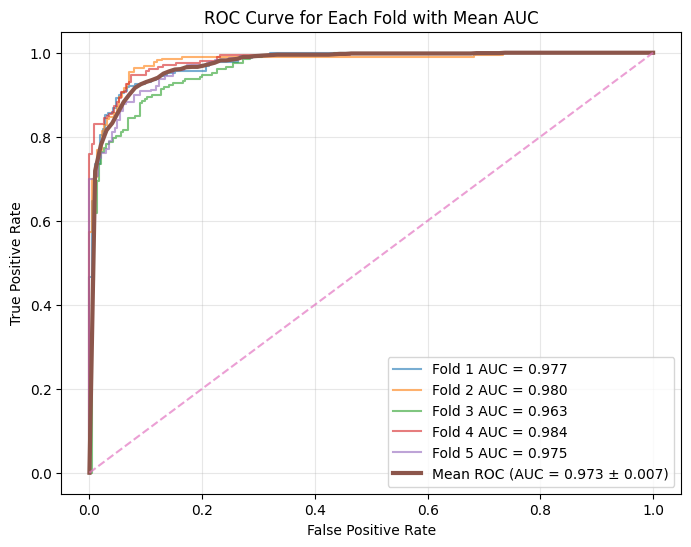


Accuracy of each fold: 
 [0.9230769230769231, 0.9230769230769231, 0.8936651583710408, 0.9160997732426304, 0.9070294784580499]

Standard deviation of accuracy: 
 0.011147543669785008

Run time is 0.31721444599999415 seconds: 

[[ 989  115]
 [  78 1026]]
              precision    recall  f1-score   support

        high      0.927     0.896     0.911      1104
         low      0.899     0.929     0.914      1104

    accuracy                          0.913      2208
   macro avg      0.913     0.913     0.913      2208
weighted avg      0.913     0.913     0.913      2208

Accuracy 0.9125905797101449
Specficity 0.8958333333333334
Sensitivity 0.9293478260869565


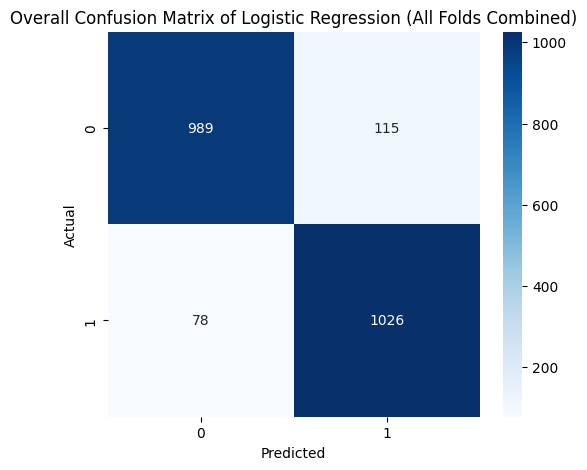

In [ ]:
#ROC curve and summary plots for 5-fold CV of LogReg
from sklearn.metrics import auc
import seaborn as sns

cv = KFold(n_splits=5, random_state=2, shuffle=True)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

plt.figure(figsize=(8, 6))

acc_score = []
Truth = []
Output = []

start_time_cv = timeit.default_timer()

for fold, (train_idx, test_idx) in enumerate(cv.split(X), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model = LogisticRegression(solver='liblinear')
    model.fit(X_train, y_train)

    pred_values = model.predict(X_test)
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    Truth.extend(y_test)
    Output.extend(pred_values)
    pos_class_idx = np.where(model.classes_ == 'high')[0][0]
    y_score = model.predict_proba(X_test)[:, pos_class_idx]
    y_binary = np.where(y_test == 'high', 1, 0)
    fpr, tpr, _ = roc_curve(y_binary, y_score)
    fold_auc = auc(fpr, tpr)
    aucs.append(fold_auc)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    plt.plot(fpr, tpr, alpha=0.6, label=f"Fold {fold} AUC = {fold_auc:.3f}")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    linewidth=3,
    label=f"Mean ROC (AUC = {mean_auc:.3f} \u00B1 {std_auc:.3f})"
)

plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Fold with Mean AUC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

elapsed_cv = timeit.default_timer() - start_time_cv
print('\nAccuracy of each fold: \n', acc_score)
print('\nStandard deviation of accuracy: \n', np.std(acc_score))
print("\nRun time is %s seconds: \n" % elapsed_cv)

overall_accuracy = accuracy_score(Truth, Output)
cm_overall = confusion_matrix(Truth, Output)
overall_specificity = cm_overall[0, 0] / (cm_overall[0, 0] + cm_overall[0, 1])
overall_sensitivity = cm_overall[1, 1] / (cm_overall[1, 0] + cm_overall[1, 1])

print(cm_overall)
print(classification_report(Truth, Output, digits=3))

print(f"Accuracy {overall_accuracy}")
print(f"Specficity {overall_specificity}")
print(f"Sensitivity {overall_sensitivity}")

plt.figure(figsize=(6, 5))
sns.heatmap(cm_overall, annot=True, fmt="d", cmap="Blues", cbar=True)
plt.title("Overall Confusion Matrix of Logistic Regression (All Folds Combined)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

### Linear Discriminant Analysis (LDA)

### LDA Full Dataset


In [ ]:
#summary of full data for LDA
start_time = timeit.default_timer()

model = LinearDiscriminantAnalysis()
model.fit(X, y)

y_pred_full = model.predict(X)

print(confusion_matrix(y, y_pred_full))
print(classification_report(y, y_pred_full, digits=3))
accuracy = accuracy_score(y, y_pred_full)
specificity = confusion_matrix(y, y_pred_full)[0, 0] / (confusion_matrix(y, y_pred_full)[0, 0] + confusion_matrix(y, y_pred_full)[0, 1])
sensitivity = confusion_matrix(y, y_pred_full)[1, 1] / (confusion_matrix(y, y_pred_full)[1, 0] + confusion_matrix(y, y_pred_full)[1, 1])
runtime = timeit.default_timer() - start_time

print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)


[[ 937  167]
 [  59 1045]]
              precision    recall  f1-score   support

        high      0.941     0.849     0.892      1104
         low      0.862     0.947     0.902      1104

    accuracy                          0.898      2208
   macro avg      0.901     0.898     0.897      2208
weighted avg      0.901     0.898     0.897      2208

Accuracy 0.8976449275362319
Specficity 0.8487318840579711
Sensitivity 0.9465579710144928
Run time is 0.08232037999999875 seconds


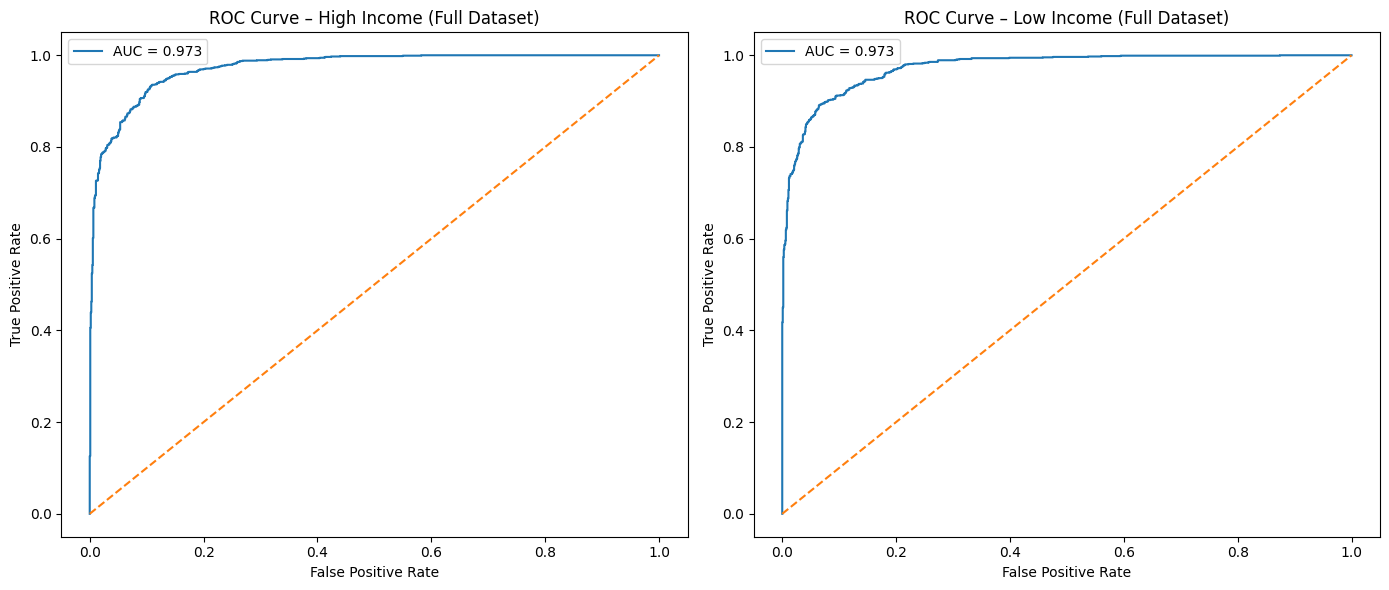

In [ ]:
#ROC curves for full data of LDA
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]

y_prob_high = model.predict_proba(X)[:, pos_index_high]
y_binary_high = np.where(y == 'high', 1, 0)

auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)

axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (Full Dataset)")
axes[0].legend()

y_prob_low = model.predict_proba(X)[:, neg_index_low]
y_binary_low = np.where(y == 'low', 1, 0)
auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)
axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (Full Dataset)")
axes[1].legend()

plt.tight_layout()
plt.show()

### LDA with 50% Validation

In [ ]:
#summary of 50/50 split data for LDA
start_time = timeit.default_timer()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)
y_pred_val = model.predict(X_test)

print(confusion_matrix(y_test, y_pred_val))
print(classification_report(y_test, y_pred_val, digits=3))
accuracy = accuracy_score(y_test, y_pred_val)
specificity = confusion_matrix(y_test, y_pred_val)[0, 0] / (confusion_matrix(y_test, y_pred_val)[0, 0] + confusion_matrix(y_test, y_pred_val)[0, 1])
sensitivity = confusion_matrix(y_test, y_pred_val)[1, 1] / (confusion_matrix(y_test, y_pred_val)[1, 0] + confusion_matrix(y_test, y_pred_val)[1, 1])
runtime = timeit.default_timer() - start_time

print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)

[[467  82]
 [ 28 527]]
              precision    recall  f1-score   support

        high      0.943     0.851     0.895       549
         low      0.865     0.950     0.905       555

    accuracy                          0.900      1104
   macro avg      0.904     0.900     0.900      1104
weighted avg      0.904     0.900     0.900      1104

Accuracy 0.9003623188405797
Specficity 0.8506375227686703
Sensitivity 0.9495495495495495
Run time is 0.041419603000008465 seconds


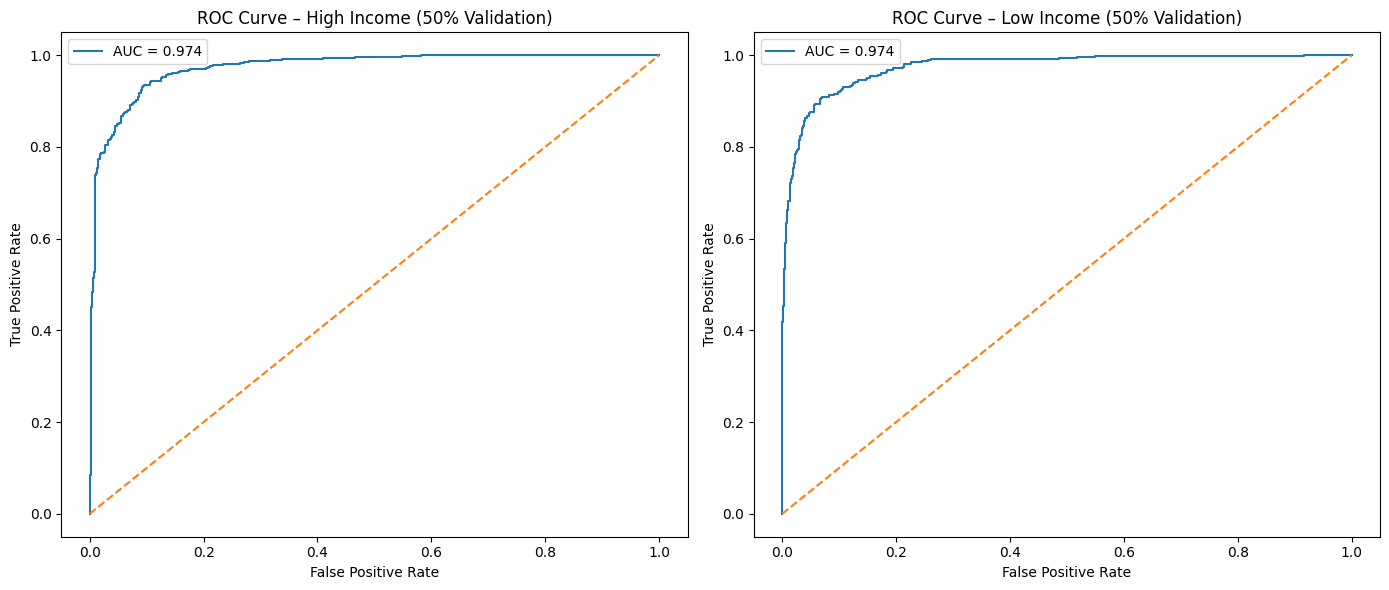

In [ ]:
#ROC curves for 50/50 split data for LDA
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]

y_prob_high = model.predict_proba(X_test)[:, pos_index_high]
y_binary_high = np.where(y_test == 'high', 1, 0)

auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)

axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (50% Validation)")
axes[0].legend()
y_prob_low = model.predict_proba(X_test)[:, neg_index_low]
y_binary_low = np.where(y_test == 'low', 1, 0)
auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)
axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (50% Validation)")
axes[1].legend()
plt.tight_layout()
plt.show()

### LDA with Cross Validation


In [ ]:
#summary of 5-fold CV for LDA
start_time = timeit.default_timer()
acc_score = []
Truth = []
Output = []
all_y_binary_high = []
all_y_prob_high = []
all_y_binary_low = []
all_y_prob_low = []

for fold, (train_index, test_index) in enumerate(crossvalidation.split(X), 1):
    print(f"\nFold {fold}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = LinearDiscriminantAnalysis()

    model.fit(X_train, y_train)

    pred_values = model.predict(X_test)

    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)

    Truth.extend(y_test)
    Output.extend(pred_values)

    print(confusion_matrix(y_test, pred_values))
    print(classification_report(y_test, pred_values, digits=3))

    plt.tight_layout()
    plt.show()


elapsed = timeit.default_timer() - start_time
accuracy = accuracy_score(Truth, Output)
specificity = confusion_matrix(Truth, Output)[0, 0] / (confusion_matrix(Truth, Output)[0, 0] + confusion_matrix(Truth, Output)[0, 1])
sensitivity = confusion_matrix(Truth, Output)[1, 1] / (confusion_matrix(Truth, Output)[1, 0] + confusion_matrix(Truth, Output)[1, 1])


Fold 1
[[197  33]
 [ 10 202]]
              precision    recall  f1-score   support

        high      0.952     0.857     0.902       230
         low      0.860     0.953     0.904       212

    accuracy                          0.903       442
   macro avg      0.906     0.905     0.903       442
weighted avg      0.908     0.903     0.903       442



<Figure size 640x480 with 0 Axes>


Fold 2
[[187  29]
 [ 10 216]]
              precision    recall  f1-score   support

        high      0.949     0.866     0.906       216
         low      0.882     0.956     0.917       226

    accuracy                          0.912       442
   macro avg      0.915     0.911     0.911       442
weighted avg      0.915     0.912     0.912       442



<Figure size 640x480 with 0 Axes>


Fold 3
[[171  36]
 [ 19 216]]
              precision    recall  f1-score   support

        high      0.900     0.826     0.861       207
         low      0.857     0.919     0.887       235

    accuracy                          0.876       442
   macro avg      0.879     0.873     0.874       442
weighted avg      0.877     0.876     0.875       442



<Figure size 640x480 with 0 Axes>


Fold 4
[[181  31]
 [  9 220]]
              precision    recall  f1-score   support

        high      0.953     0.854     0.900       212
         low      0.876     0.961     0.917       229

    accuracy                          0.909       441
   macro avg      0.915     0.907     0.909       441
weighted avg      0.913     0.909     0.909       441



<Figure size 640x480 with 0 Axes>


Fold 5
[[200  39]
 [ 13 189]]
              precision    recall  f1-score   support

        high      0.939     0.837     0.885       239
         low      0.829     0.936     0.879       202

    accuracy                          0.882       441
   macro avg      0.884     0.886     0.882       441
weighted avg      0.889     0.882     0.882       441



<Figure size 640x480 with 0 Axes>

### Results of LDA with CV

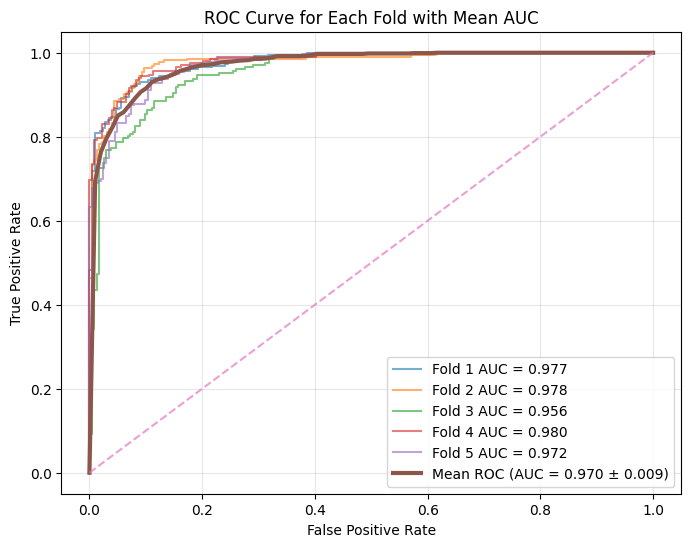


Accuracy of each fold: 
 [0.9027149321266968, 0.9117647058823529, 0.8755656108597285, 0.909297052154195, 0.8820861678004536]

Standard deviation of accuracy: 
 0.014704956595596601

Run time is 0.2568 seconds: 

[[ 936  168]
 [  61 1043]]
              precision    recall  f1-score   support

        high      0.939     0.848     0.891      1104
         low      0.861     0.945     0.901      1104

    accuracy                          0.896      2208
   macro avg      0.900     0.896     0.896      2208
weighted avg      0.900     0.896     0.896      2208

Accuracy 0.896286231884058
Specficity 0.8478260869565217
Sensitivity 0.9447463768115942
             Predicted_high  Predicted_low
Actual_high             936            168
Actual_low               61           1043


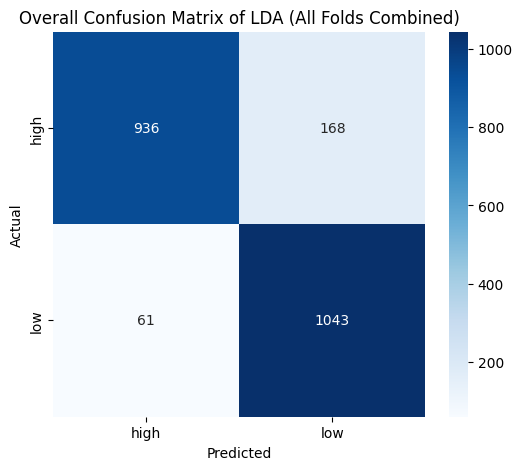

In [ ]:
#ROC curve and summary plots for 5-fold CV for LDA
from sklearn.metrics import auc
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
cv = KFold(n_splits=5, random_state=2, shuffle=True)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 6))
acc_score = []
Truth = []
Output = []
start_time_cv = timeit.default_timer()
le = LabelEncoder()
le.fit(y)

for fold, (train_idx, test_idx) in enumerate(cv.split(X), 1):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    Truth.extend(y_test)
    Output.extend(pred_values)
    pos_class_idx = np.where(model.classes_ == 'high')[0][0]
    y_score = model.predict_proba(X_test)[:, pos_class_idx]
    y_binary = np.where(y_test == 'high', 1, 0)
    fpr, tpr, _ = roc_curve(y_binary, y_score)
    fold_auc = auc(fpr, tpr)
    aucs.append(fold_auc)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    plt.plot(fpr, tpr, alpha=0.6, label=f"Fold {fold} AUC = {fold_auc:.3f}")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    linewidth=3,
    label=f"Mean ROC (AUC = {mean_auc:.3f} \u00B1 {std_auc:.3f})"
)

plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Fold with Mean AUC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
elapsed_cv = timeit.default_timer() - start_time_cv
print('\nAccuracy of each fold: \n', acc_score)
print('\nStandard deviation of accuracy: \n', np.std(acc_score))
print(f"\nRun time is {elapsed_cv:.4f} seconds: \n")

overall_accuracy = accuracy_score(Truth, Output)
cm_overall = confusion_matrix(Truth, Output)
overall_specificity = cm_overall[0, 0] / (cm_overall[0, 0] + cm_overall[0, 1])
overall_sensitivity = cm_overall[1, 1] / (cm_overall[1, 0] + cm_overall[1, 1])

print(cm_overall)
print(classification_report(Truth, Output, digits=3))

print(f"Accuracy {overall_accuracy}")
print(f"Specficity {overall_specificity}")
print(f"Sensitivity {overall_sensitivity}")
labels_display = ['high', 'low']
cm_df_overall = pd.DataFrame(
    cm_overall,
    index=[f"Actual_{l}" for l in labels_display],
    columns=[f"Predicted_{l}" for l in labels_display]
)
print(cm_df_overall)

def plot_confusion_matrix(cm_data, display_labels, title="Confusion Matrix"): # Added display_labels parameter
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_data, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=display_labels, yticklabels=display_labels) # Use display_labels for axis ticks
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
plot_confusion_matrix(cm_overall, labels_display, title="Overall Confusion Matrix of LDA (All Folds Combined)")

### Quadratic Descriminant Analysis (QDA)

### QDA on Full Dataset

In [ ]:
#summary of full data for QDA
start_time = timeit.default_timer()

model = QuadraticDiscriminantAnalysis()
model.fit(X, y)

y_pred_full = model.predict(X)

print(confusion_matrix(y, y_pred_full))
print(classification_report(y, y_pred_full, digits=3))
accuracy = accuracy_score(y, y_pred_full)
specificity = confusion_matrix(y, y_pred_full)[0, 0] / (confusion_matrix(y, y_pred_full)[0, 0] + confusion_matrix(y, y_pred_full)[0, 1])
sensitivity = confusion_matrix(y, y_pred_full)[1, 1] / (confusion_matrix(y, y_pred_full)[1, 0] + confusion_matrix(y, y_pred_full)[1, 1])
runtime = timeit.default_timer() - start_time

print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)


[[ 919  185]
 [  45 1059]]
              precision    recall  f1-score   support

        high      0.953     0.832     0.889      1104
         low      0.851     0.959     0.902      1104

    accuracy                          0.896      2208
   macro avg      0.902     0.896     0.895      2208
weighted avg      0.902     0.896     0.895      2208

Accuracy 0.8958333333333334
Specficity 0.832427536231884
Sensitivity 0.9592391304347826
Run time is 0.07134770900000831 seconds


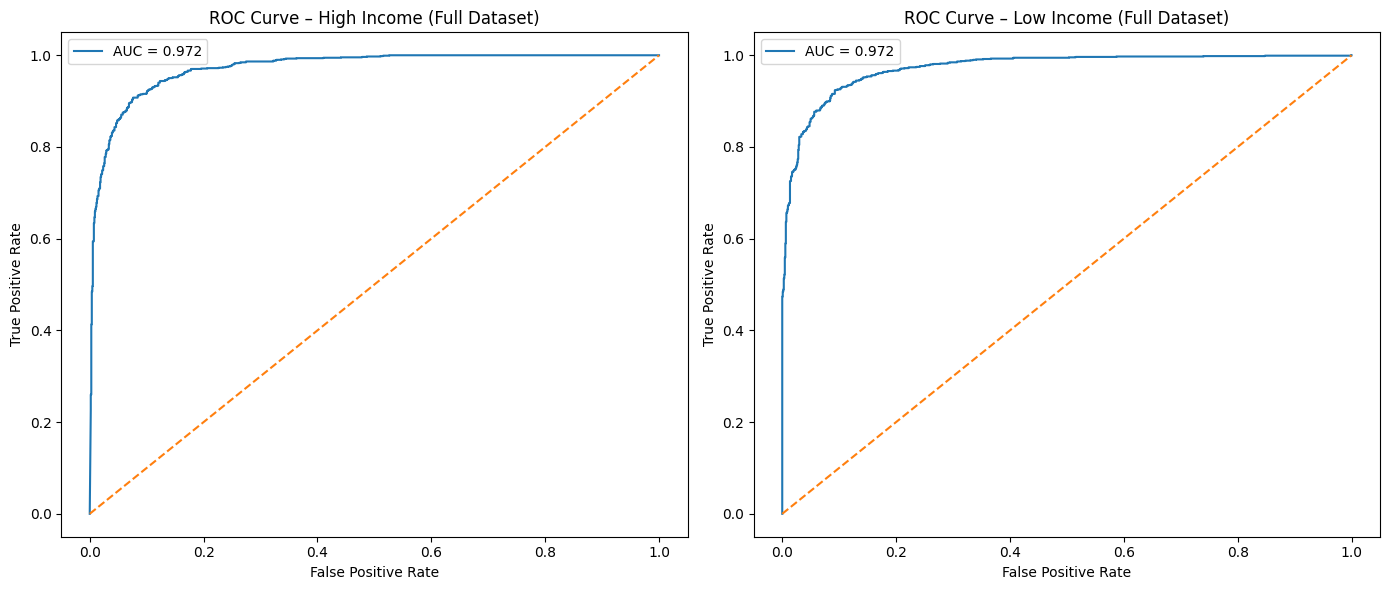

In [ ]:
#ROC curves for QDA
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]

y_prob_high = model.predict_proba(X)[:, pos_index_high]
y_binary_high = np.where(y == 'high', 1, 0)

auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)

axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (Full Dataset)")
axes[0].legend()
y_prob_low = model.predict_proba(X)[:, neg_index_low]
y_binary_low = np.where(y == 'low', 1, 0)

auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)

axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (Full Dataset)")
axes[1].legend()

plt.tight_layout()
plt.show()

### QDA with 50% Validation

In [ ]:
#summary of 50/50 split for QDA
start_time = timeit.default_timer()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

model = QuadraticDiscriminantAnalysis()
model.fit(X_train, y_train)

y_pred_val = model.predict(X_test)

print(confusion_matrix(y_test, y_pred_val))
print(classification_report(y_test, y_pred_val, digits=3))
accuracy = accuracy_score(y_test, y_pred_val)
specificity = confusion_matrix(y_test, y_pred_val)[0, 0] / (confusion_matrix(y_test, y_pred_val)[0, 0] + confusion_matrix(y_test, y_pred_val)[0, 1])
sensitivity = confusion_matrix(y_test, y_pred_val)[1, 1] / (confusion_matrix(y_test, y_pred_val)[1, 0] + confusion_matrix(y_test, y_pred_val)[1, 1])
runtime = timeit.default_timer() - start_time

print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)

[[468  81]
 [ 38 517]]
              precision    recall  f1-score   support

        high      0.925     0.852     0.887       549
         low      0.865     0.932     0.897       555

    accuracy                          0.892      1104
   macro avg      0.895     0.892     0.892      1104
weighted avg      0.895     0.892     0.892      1104

Accuracy 0.8922101449275363
Specficity 0.8524590163934426
Sensitivity 0.9315315315315316
Run time is 0.03966411700000094 seconds


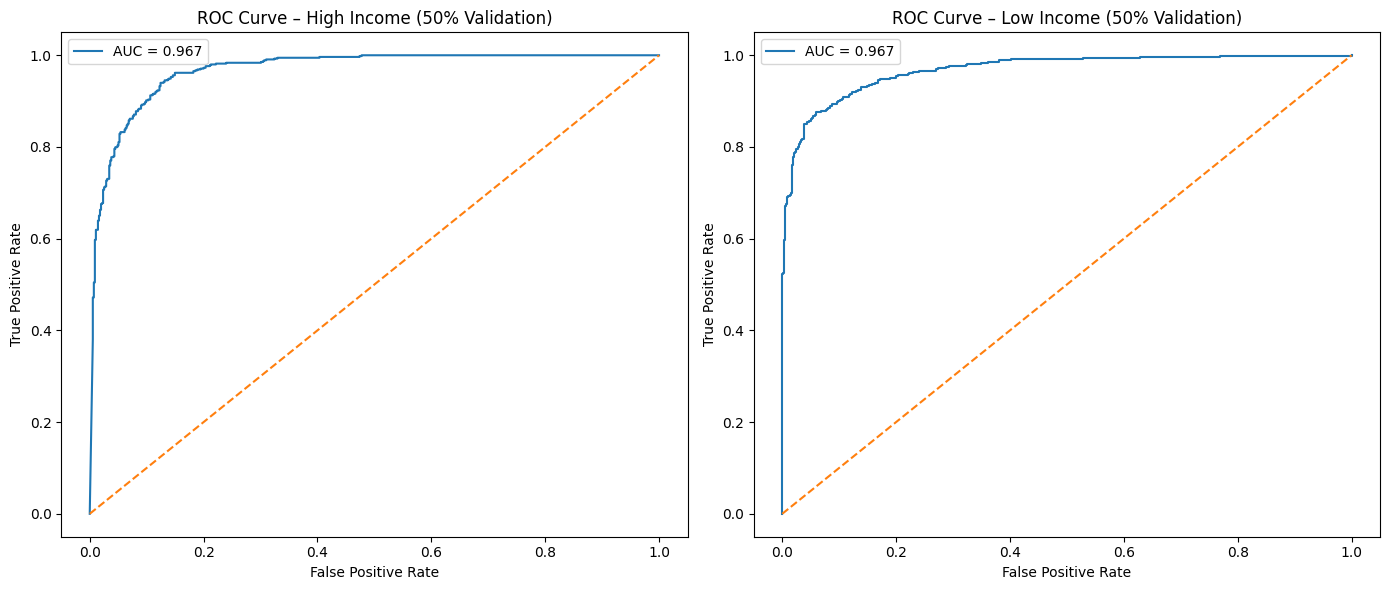

In [ ]:
#ROC curve of 50/50 split for QDA
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]
y_prob_high = model.predict_proba(X_test)[:, pos_index_high]
y_binary_high = np.where(y_test == 'high', 1, 0)
auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)
axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (50% Validation)")
axes[0].legend()
y_prob_low = model.predict_proba(X_test)[:, neg_index_low]
y_binary_low = np.where(y_test == 'low', 1, 0)

auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)

axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (50% Validation)")
axes[1].legend()

plt.tight_layout()
plt.show()

### QDA CV


In [ ]:
#summary of 5-fold CV for QDA
start_time = timeit.default_timer()
acc_score = []
Truth = []
Output = []
all_y_binary_high = []
all_y_prob_high = []
all_y_binary_low = []
all_y_prob_low = []

for fold, (train_index, test_index) in enumerate(crossvalidation.split(X), 1):
    print(f"\nFold {fold}")

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    Truth.extend(y_test)
    Output.extend(pred_values)
    print(confusion_matrix(y_test, pred_values))
    print(classification_report(y_test, pred_values, digits=3))

    plt.tight_layout()
    plt.show()
elapsed = timeit.default_timer() - start_time

accuracy = accuracy_score(Truth, Output)
specificity = confusion_matrix(Truth, Output)[0, 0] / (confusion_matrix(Truth, Output)[0, 0] + confusion_matrix(Truth, Output)[0, 1])
sensitivity = confusion_matrix(Truth, Output)[1, 1] / (confusion_matrix(Truth, Output)[1, 0] + confusion_matrix(Truth, Output)[1, 1])




Fold 1
[[195  35]
 [ 11 201]]
              precision    recall  f1-score   support

        high      0.947     0.848     0.894       230
         low      0.852     0.948     0.897       212

    accuracy                          0.896       442
   macro avg      0.899     0.898     0.896       442
weighted avg      0.901     0.896     0.896       442



<Figure size 640x480 with 0 Axes>


Fold 2
[[178  38]
 [  7 219]]
              precision    recall  f1-score   support

        high      0.962     0.824     0.888       216
         low      0.852     0.969     0.907       226

    accuracy                          0.898       442
   macro avg      0.907     0.897     0.897       442
weighted avg      0.906     0.898     0.898       442



<Figure size 640x480 with 0 Axes>


Fold 3
[[169  38]
 [ 16 219]]
              precision    recall  f1-score   support

        high      0.914     0.816     0.862       207
         low      0.852     0.932     0.890       235

    accuracy                          0.878       442
   macro avg      0.883     0.874     0.876       442
weighted avg      0.881     0.878     0.877       442



<Figure size 640x480 with 0 Axes>


Fold 4
[[174  38]
 [  5 224]]
              precision    recall  f1-score   support

        high      0.972     0.821     0.890       212
         low      0.855     0.978     0.912       229

    accuracy                          0.902       441
   macro avg      0.914     0.899     0.901       441
weighted avg      0.911     0.902     0.902       441



<Figure size 640x480 with 0 Axes>


Fold 5
[[199  40]
 [  8 194]]
              precision    recall  f1-score   support

        high      0.961     0.833     0.892       239
         low      0.829     0.960     0.890       202

    accuracy                          0.891       441
   macro avg      0.895     0.897     0.891       441
weighted avg      0.901     0.891     0.891       441



<Figure size 640x480 with 0 Axes>

### Results of QDA with CV

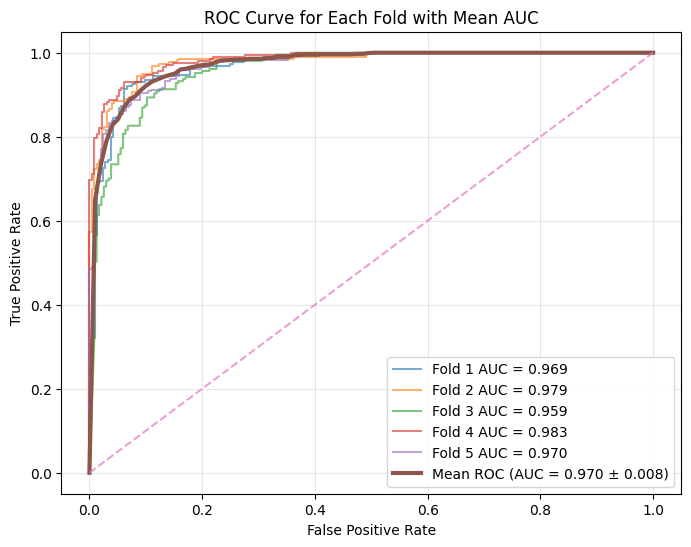


Accuracy of each fold: 
 [0.8959276018099548, 0.8981900452488688, 0.8778280542986425, 0.9024943310657596, 0.891156462585034]

Standard deviation of accuracy: 
 0.00847543685877663

Run time is 0.2467 seconds: 

[[ 915  189]
 [  47 1057]]
              precision    recall  f1-score   support

        high      0.951     0.829     0.886      1104
         low      0.848     0.957     0.900      1104

    accuracy                          0.893      2208
   macro avg      0.900     0.893     0.893      2208
weighted avg      0.900     0.893     0.893      2208

Accuracy 0.8931159420289855
Specficity 0.8288043478260869
Sensitivity 0.957427536231884
             Predicted_high  Predicted_low
Actual_high             915            189
Actual_low               47           1057


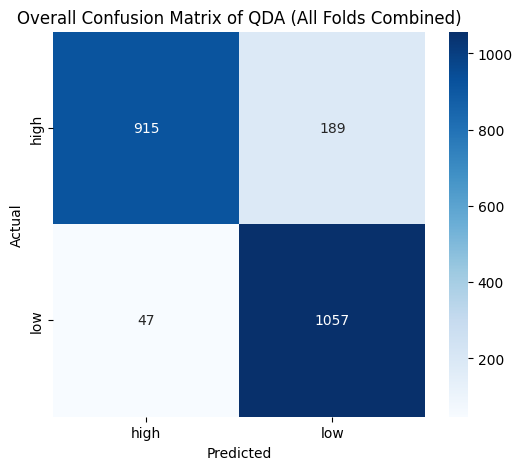

In [ ]:
#ROC curves and summary plots for 5-fold CV of QDA
from sklearn.metrics import auc
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
cv = KFold(n_splits=5, random_state=2, shuffle=True)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 6))
acc_score = []
Truth = []
Output = []

start_time_cv = timeit.default_timer()
le = LabelEncoder()
le.fit(y)

for fold, (train_idx, test_idx) in enumerate(cv.split(X), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = QuadraticDiscriminantAnalysis()
    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    Truth.extend(y_test)
    Output.extend(pred_values)
    pos_class_idx = np.where(model.classes_ == 'high')[0][0]
    y_score = model.predict_proba(X_test)[:, pos_class_idx]
    y_binary = np.where(y_test == 'high', 1, 0)
    fpr, tpr, _ = roc_curve(y_binary, y_score)
    fold_auc = auc(fpr, tpr)
    aucs.append(fold_auc)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    plt.plot(fpr, tpr, alpha=0.6, label=f"Fold {fold} AUC = {fold_auc:.3f}")

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    linewidth=3,
    label=f"Mean ROC (AUC = {mean_auc:.3f} \u00B1 {std_auc:.3f})"
)
plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.7)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Fold with Mean AUC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
elapsed_cv = timeit.default_timer() - start_time_cv

print('\nAccuracy of each fold: \n', acc_score)
print('\nStandard deviation of accuracy: \n', np.std(acc_score))
print(f"\nRun time is {elapsed_cv:.4f} seconds: \n")
overall_accuracy = accuracy_score(Truth, Output)
cm_overall = confusion_matrix(Truth, Output)
overall_specificity = cm_overall[0, 0] / (cm_overall[0, 0] + cm_overall[0, 1])
overall_sensitivity = cm_overall[1, 1] / (cm_overall[1, 0] + cm_overall[1, 1])

print(cm_overall)
print(classification_report(Truth, Output, digits=3))
print(f"Accuracy {overall_accuracy}")
print(f"Specficity {overall_specificity}")
print(f"Sensitivity {overall_sensitivity}")
labels_display = ['high', 'low']
cm_df_overall = pd.DataFrame(
    cm_overall,
    index=[f"Actual_{l}" for l in labels_display],
    columns=[f"Predicted_{l}" for l in labels_display]
)
print(cm_df_overall)

def plot_confusion_matrix(cm_data, display_labels, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_data, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=display_labels, yticklabels=display_labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion_matrix(cm_overall, labels_display, title="Overall Confusion Matrix of QDA (All Folds Combined)")

### Naive Bayes

### Naive Bayes Full Dataset

In [ ]:
#summary of full data for NB
start_time = timeit.default_timer()
model = GaussianNB()
model.fit(X, y)
y_pred_full = model.predict(X)
print(confusion_matrix(y, y_pred_full))
print(classification_report(y, y_pred_full, digits=3))
accuracy = accuracy_score(y, y_pred_full)
specificity = confusion_matrix(y, y_pred_full)[0, 0] / (confusion_matrix(y, y_pred_full)[0, 0] + confusion_matrix(y, y_pred_full)[0, 1])
sensitivity = confusion_matrix(y, y_pred_full)[1, 1] / (confusion_matrix(y, y_pred_full)[1, 0] + confusion_matrix(y, y_pred_full)[1, 1])
runtime = timeit.default_timer() - start_time

print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)


[[ 920  184]
 [  50 1054]]
              precision    recall  f1-score   support

        high      0.948     0.833     0.887      1104
         low      0.851     0.955     0.900      1104

    accuracy                          0.894      2208
   macro avg      0.900     0.894     0.894      2208
weighted avg      0.900     0.894     0.894      2208

Accuracy 0.8940217391304348
Specficity 0.8333333333333334
Sensitivity 0.9547101449275363
Run time is 0.058624863999995114 seconds


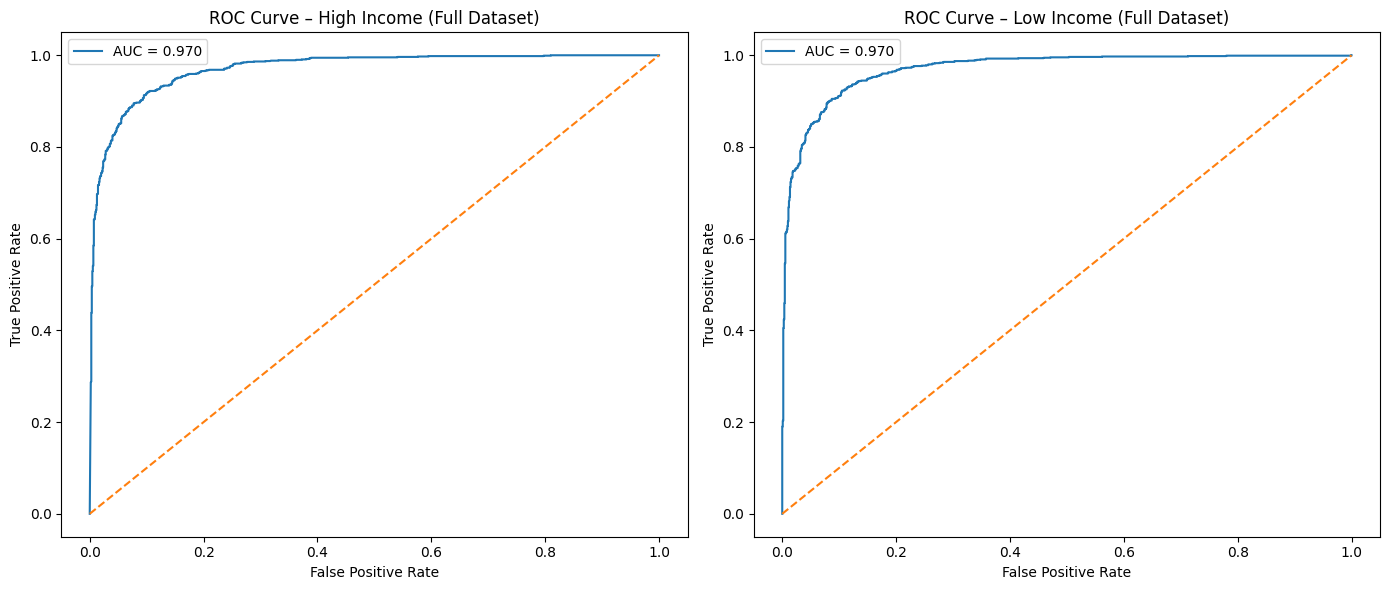

In [ ]:
#ROC curve for full data of NB
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]
y_prob_high = model.predict_proba(X)[:, pos_index_high]
y_binary_high = np.where(y == 'high', 1, 0)
auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)
axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (Full Dataset)")
axes[0].legend()
y_prob_low = model.predict_proba(X)[:, neg_index_low]
y_binary_low = np.where(y == 'low', 1, 0)

auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)

axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (Full Dataset)")
axes[1].legend()

plt.tight_layout()
plt.show()

### Naive Bayes with 50% Validation

In [ ]:
#summary of 50/50 data split for NB
start_time = timeit.default_timer()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred_val = model.predict(X_test)
print(confusion_matrix(y_test, y_pred_val))
print(classification_report(y_test, y_pred_val, digits=3))
accuracy = accuracy_score(y_test, y_pred_val)
specificity = confusion_matrix(y_test, y_pred_val)[0, 0] / (confusion_matrix(y_test, y_pred_val)[0, 0] + confusion_matrix(y_test, y_pred_val)[0, 1])
sensitivity = confusion_matrix(y_test, y_pred_val)[1, 1] / (confusion_matrix(y_test, y_pred_val)[1, 0] + confusion_matrix(y_test, y_pred_val)[1, 1])
runtime = timeit.default_timer() - start_time

print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)

[[470  79]
 [ 40 515]]
              precision    recall  f1-score   support

        high      0.922     0.856     0.888       549
         low      0.867     0.928     0.896       555

    accuracy                          0.892      1104
   macro avg      0.894     0.892     0.892      1104
weighted avg      0.894     0.892     0.892      1104

Accuracy 0.8922101449275363
Specficity 0.8561020036429873
Sensitivity 0.9279279279279279
Run time is 0.039355747000001884 seconds


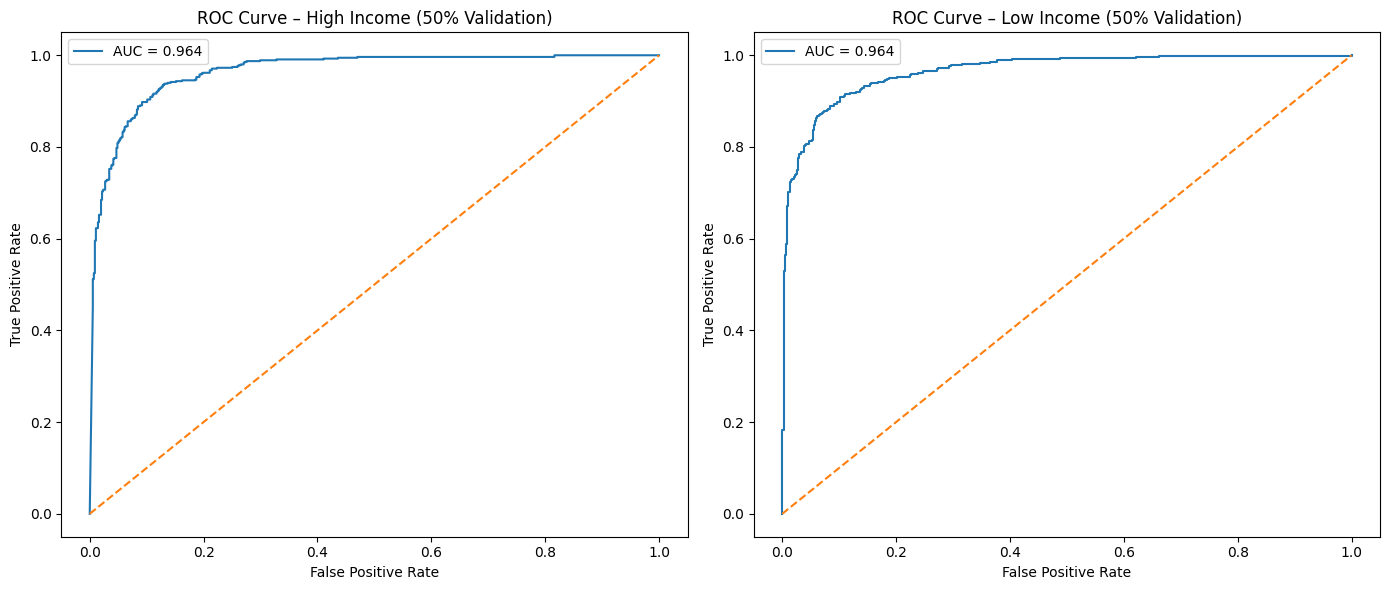

In [ ]:
#ROC curves for 50/50 data split
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]
y_prob_high = model.predict_proba(X_test)[:, pos_index_high]
y_binary_high = np.where(y_test == 'high', 1, 0)
auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)
axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (50% Validation)")
axes[0].legend()
y_prob_low = model.predict_proba(X_test)[:, neg_index_low]
y_binary_low = np.where(y_test == 'low', 1, 0)
auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)
axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (50% Validation)")
axes[1].legend()
plt.tight_layout()
plt.show()

### Naive Bayes with CV

In [ ]:
#summary of 5-fold CV for NB
start_time = timeit.default_timer()
acc_score = []
Truth = []
Output = []
crossvalidation = KFold(n_splits=5, shuffle=True, random_state=2)
for fold, (train_index, test_index) in enumerate(crossvalidation.split(X), 1):
    print(f"\nFold {fold}")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y[train_index], y[test_index]
    model = GaussianNB()
    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    Truth.extend(y_test)
    Output.extend(pred_values)
    print(confusion_matrix(y_test, pred_values))
    print(classification_report(y_test, pred_values, digits=3))

    plt.tight_layout()
    plt.show()
elapsed = timeit.default_timer() - start_time
accuracy = accuracy_score(Truth, Output)
specificity = confusion_matrix(Truth, Output)[0, 0] / (confusion_matrix(Truth, Output)[0, 0] + confusion_matrix(Truth, Output)[0, 1])
sensitivity = confusion_matrix(Truth, Output)[1, 1] / (confusion_matrix(Truth, Output)[1, 0] + confusion_matrix(Truth, Output)[1, 1])



Fold 1
[[196  34]
 [ 11 201]]
              precision    recall  f1-score   support

        high      0.947     0.852     0.897       230
         low      0.855     0.948     0.899       212

    accuracy                          0.898       442
   macro avg      0.901     0.900     0.898       442
weighted avg      0.903     0.898     0.898       442



<Figure size 640x480 with 0 Axes>


Fold 2
[[180  36]
 [  6 220]]
              precision    recall  f1-score   support

        high      0.968     0.833     0.896       216
         low      0.859     0.973     0.913       226

    accuracy                          0.905       442
   macro avg      0.914     0.903     0.904       442
weighted avg      0.912     0.905     0.904       442



<Figure size 640x480 with 0 Axes>


Fold 3
[[171  36]
 [ 19 216]]
              precision    recall  f1-score   support

        high      0.900     0.826     0.861       207
         low      0.857     0.919     0.887       235

    accuracy                          0.876       442
   macro avg      0.879     0.873     0.874       442
weighted avg      0.877     0.876     0.875       442



<Figure size 640x480 with 0 Axes>


Fold 4
[[177  35]
 [  4 225]]
              precision    recall  f1-score   support

        high      0.978     0.835     0.901       212
         low      0.865     0.983     0.920       229

    accuracy                          0.912       441
   macro avg      0.922     0.909     0.911       441
weighted avg      0.919     0.912     0.911       441



<Figure size 640x480 with 0 Axes>


Fold 5
[[198  41]
 [ 11 191]]
              precision    recall  f1-score   support

        high      0.947     0.828     0.884       239
         low      0.823     0.946     0.880       202

    accuracy                          0.882       441
   macro avg      0.885     0.887     0.882       441
weighted avg      0.891     0.882     0.882       441



<Figure size 640x480 with 0 Axes>

### Results of Naive Bayes with 5-fold

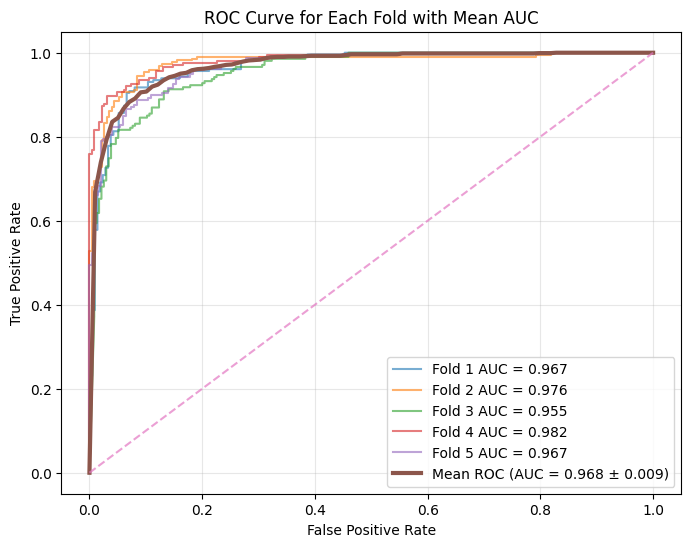


Accuracy of each fold: 
 [0.8981900452488688, 0.9049773755656109, 0.8755656108597285, 0.9115646258503401, 0.8820861678004536]

Standard deviation of accuracy: 
 0.013617671686278537

Run time is 0.2728 seconds: 

[[ 922  182]
 [  51 1053]]
              precision    recall  f1-score   support

        high      0.948     0.835     0.888      1104
         low      0.853     0.954     0.900      1104

    accuracy                          0.894      2208
   macro avg      0.900     0.894     0.894      2208
weighted avg      0.900     0.894     0.894      2208

Accuracy 0.8944746376811594
Specficity 0.8351449275362319
Sensitivity 0.9538043478260869
             Predicted_high  Predicted_low
Actual_high             922            182
Actual_low               51           1053


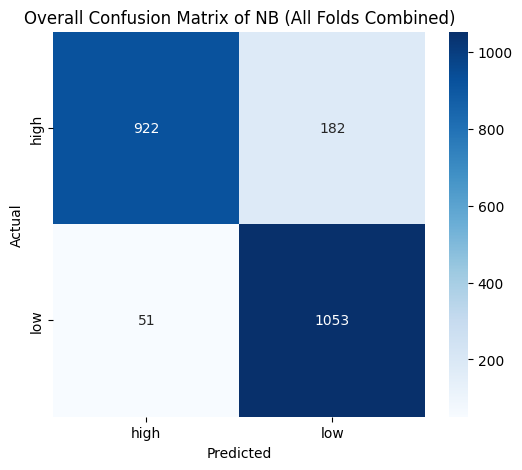

In [ ]:
#ROC curves and summary plots for 5-fold CV of NB
from sklearn.metrics import auc
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
cv = KFold(n_splits=5, random_state=2, shuffle=True)
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
plt.figure(figsize=(8, 6))
acc_score = []
Truth = []
Output = []
start_time_cv = timeit.default_timer()
le = LabelEncoder()
le.fit(y)
for fold, (train_idx, test_idx) in enumerate(cv.split(X), 1):

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    model = GaussianNB()
    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)
    acc = accuracy_score(y_test, pred_values)
    acc_score.append(acc)
    Truth.extend(y_test)
    Output.extend(pred_values)
    pos_class_idx = np.where(model.classes_ == 'high')[0][0]
    y_score = model.predict_proba(X_test)[:, pos_class_idx]
    y_binary = np.where(y_test == 'high', 1, 0)
    fpr, tpr, _ = roc_curve(y_binary, y_score)
    fold_auc = auc(fpr, tpr)
    aucs.append(fold_auc)
    tpr_interp = np.interp(mean_fpr, fpr, tpr)
    tpr_interp[0] = 0.0
    tprs.append(tpr_interp)
    plt.plot(fpr, tpr, alpha=0.6, label=f"Fold {fold} AUC = {fold_auc:.3f}")
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)

plt.plot(
    mean_fpr,
    mean_tpr,
    linewidth=3,
    label=f"Mean ROC (AUC = {mean_auc:.3f} \u00B1 {std_auc:.3f})"
)

plt.plot([0, 1], [0, 1], linestyle="--", alpha=0.7)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Each Fold with Mean AUC")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

elapsed_cv = timeit.default_timer() - start_time_cv
print('\nAccuracy of each fold: \n', acc_score)
print('\nStandard deviation of accuracy: \n', np.std(acc_score))
print(f"\nRun time is {elapsed_cv:.4f} seconds: \n")
overall_accuracy = accuracy_score(Truth, Output)
cm_overall = confusion_matrix(Truth, Output)
overall_specificity = cm_overall[0, 0] / (cm_overall[0, 0] + cm_overall[0, 1])
overall_sensitivity = cm_overall[1, 1] / (cm_overall[1, 0] + cm_overall[1, 1])
print(cm_overall)
print(classification_report(Truth, Output, digits=3))
print(f"Accuracy {overall_accuracy}")
print(f"Specficity {overall_specificity}")
print(f"Sensitivity {overall_sensitivity}")

labels_display = ['high', 'low']
cm_df_overall = pd.DataFrame(
    cm_overall,
    index=[f"Actual_{l}" for l in labels_display],
    columns=[f"Predicted_{l}" for l in labels_display]
)
print(cm_df_overall)

def plot_confusion_matrix(cm_data, display_labels, title="Confusion Matrix"):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm_data, annot=True, fmt="d", cmap="Blues", cbar=True,
                xticklabels=display_labels, yticklabels=display_labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
plot_confusion_matrix(cm_overall, labels_display, title="Overall Confusion Matrix of NB (All Folds Combined)")

### KNN

### KNN Full Dataset

In [ ]:
#summary of full data for KNN
start_time = timeit.default_timer()
model = neighbors.KNeighborsClassifier(n_neighbors = 10)
model.fit(X, y)
y_pred_full = model.predict(X)
print(confusion_matrix(y, y_pred_full))
print(classification_report(y, y_pred_full, digits=3))
accuracy = accuracy_score(y, y_pred_full)
specificity = confusion_matrix(y, y_pred_full)[0, 0] / (confusion_matrix(y, y_pred_full)[0, 0] + confusion_matrix(y, y_pred_full)[0, 1])
sensitivity = confusion_matrix(y, y_pred_full)[1, 1] / (confusion_matrix(y, y_pred_full)[1, 0] + confusion_matrix(y, y_pred_full)[1, 1])
runtime = timeit.default_timer() - start_time
print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)


[[993 111]
 [115 989]]
              precision    recall  f1-score   support

        high      0.896     0.899     0.898      1104
         low      0.899     0.896     0.897      1104

    accuracy                          0.898      2208
   macro avg      0.898     0.898     0.898      2208
weighted avg      0.898     0.898     0.898      2208

Accuracy 0.8976449275362319
Specficity 0.8994565217391305
Sensitivity 0.8958333333333334
Run time is 0.17885682700034522 seconds


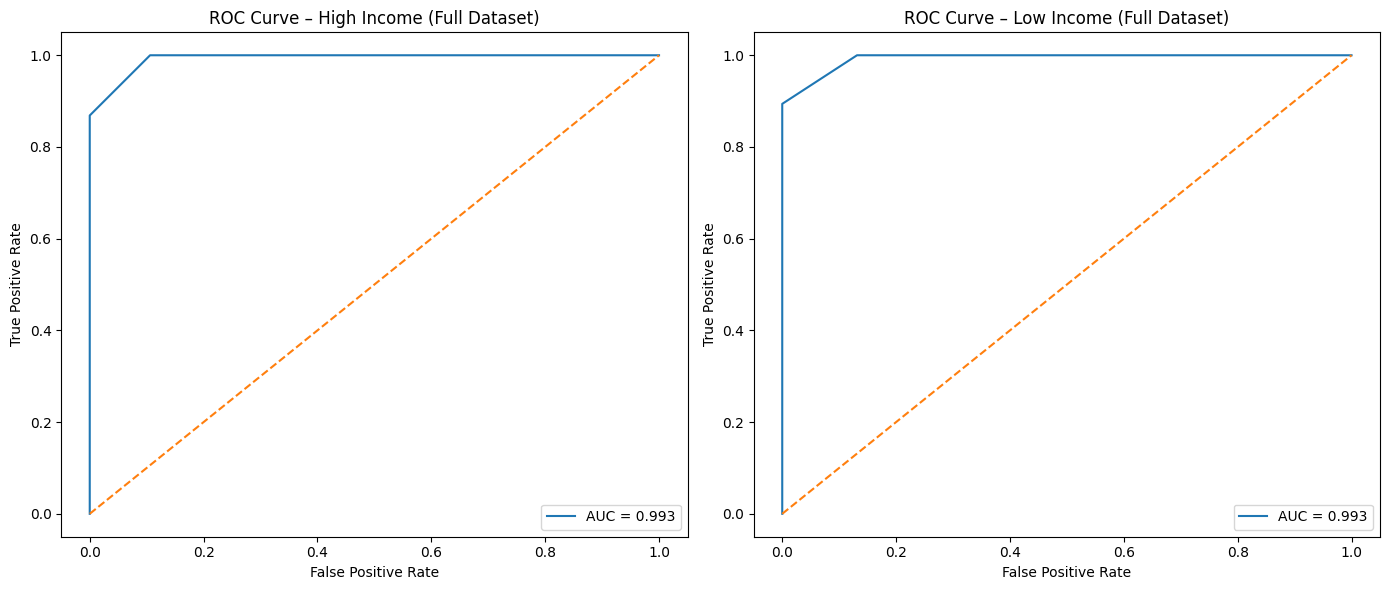

In [ ]:
#ROC curves for full data of KNN
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]
y_prob_high = model.predict_proba(X)[:, pos_index_high]
y_binary_high = np.where(y == 'high', 1, 0)
auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)
axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (Full Dataset)")
axes[0].legend()
y_prob_low = model.predict_proba(X)[:, neg_index_low]
y_binary_low = np.where(y == 'low', 1, 0)
auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)
axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (Full Dataset)")
axes[1].legend()
plt.tight_layout()
plt.show()

### KNN with 50% Validation

In [ ]:
#summary of 50/50 data split of KNN
start_time = timeit.default_timer()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)
model = neighbors.KNeighborsClassifier(n_neighbors = 10)
model.fit(X_train, y_train)
y_pred_val = model.predict(X_test)
print(confusion_matrix(y_test, y_pred_val))
print(classification_report(y_test, y_pred_val, digits=3))
accuracy = accuracy_score(y_test, y_pred_val)
specificity = confusion_matrix(y_test, y_pred_val)[0, 0] / (confusion_matrix(y_test, y_pred_val)[0, 0] + confusion_matrix(y_test, y_pred_val)[0, 1])
sensitivity = confusion_matrix(y_test, y_pred_val)[1, 1] / (confusion_matrix(y_test, y_pred_val)[1, 0] + confusion_matrix(y_test, y_pred_val)[1, 1])
runtime = timeit.default_timer() - start_time
print(f"Accuracy {accuracy}")
print(f"Specficity {specificity}")
print(f"Sensitivity {sensitivity}")
print("Run time is %s seconds" % runtime)

[[485  64]
 [ 51 504]]
              precision    recall  f1-score   support

        high      0.905     0.883     0.894       549
         low      0.887     0.908     0.898       555

    accuracy                          0.896      1104
   macro avg      0.896     0.896     0.896      1104
weighted avg      0.896     0.896     0.896      1104

Accuracy 0.8958333333333334
Specficity 0.8834244080145719
Sensitivity 0.9081081081081082
Run time is 0.09222255099939503 seconds


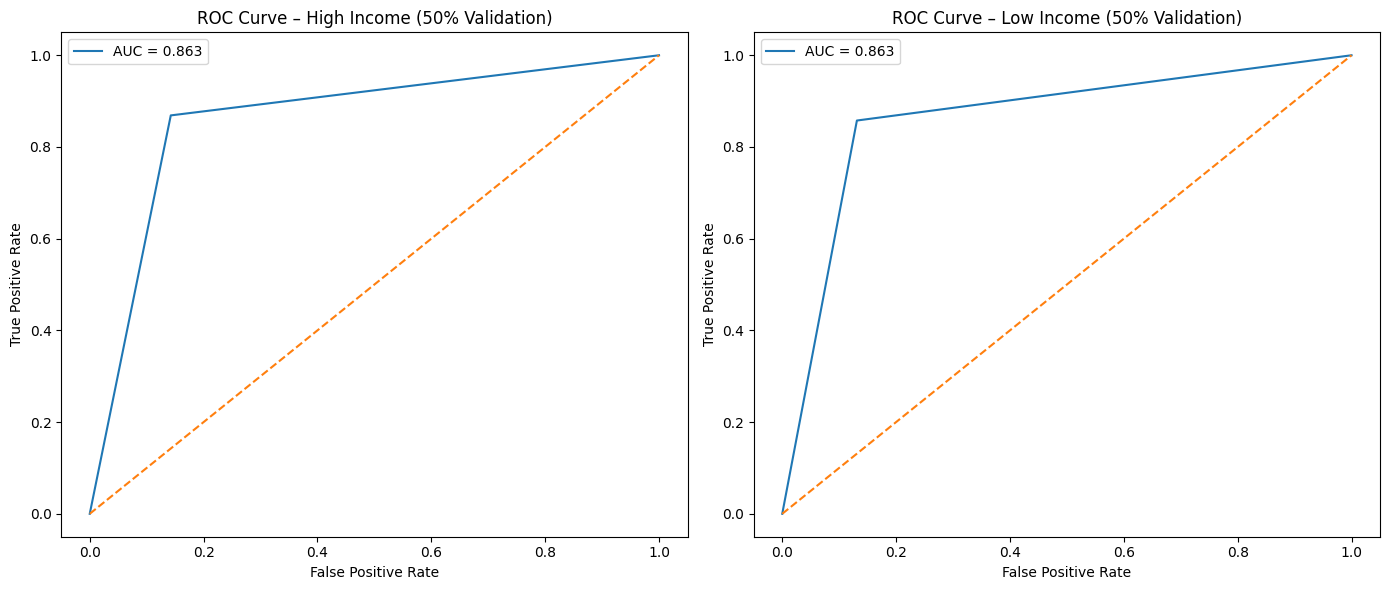

In [ ]:
#ROC curves for 50/50 data split of KNN
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
pos_index_high = np.where(model.classes_ == 'high')[0][0]
neg_index_low = np.where(model.classes_ == 'low')[0][0]
y_prob_high = model.predict_proba(X_test)[:, pos_index_high]
y_binary_high = np.where(y_test == 'high', 1, 0)
auc_high = roc_auc_score(y_binary_high, y_prob_high)
fpr_high, tpr_high, _ = roc_curve(y_binary_high, y_prob_high)
axes[0].plot(fpr_high, tpr_high, label=f"AUC = {auc_high:.3f}")
axes[0].plot([0, 1], [0, 1], "--")
axes[0].set_xlabel("False Positive Rate")
axes[0].set_ylabel("True Positive Rate")
axes[0].set_title("ROC Curve – High Income (50% Validation)")
axes[0].legend()
y_prob_low = model.predict_proba(X_test)[:, neg_index_low]
y_binary_low = np.where(y_test == 'low', 1, 0)

auc_low = roc_auc_score(y_binary_low, y_prob_low)
fpr_low, tpr_low, _ = roc_curve(y_binary_low, y_prob_low)

axes[1].plot(fpr_low, tpr_low, label=f"AUC = {auc_low:.3f}")
axes[1].plot([0, 1], [0, 1], "--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("ROC Curve – Low Income (50% Validation)")
axes[1].legend()

plt.tight_layout()
plt.show()

In [ ]:
#Display of KNN of each K for 5-fold CV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import KFold, cross_val_score
import timeit
results = []
for k in range(1, 11):

    print(f"\n=== K = {k} ===")

    knn = neighbors.KNeighborsClassifier(n_neighbors=k)
    fold_accuracies = []
    fold_sensitivities = []
    fold_specificities = []

    start_time = timeit.default_timer()

    for train_idx, test_idx in crossvalidation.split(X):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = knn.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        cm = confusion_matrix(y_test, y_pred)
        TN, FP, FN, TP = cm.ravel()
        acc = (TP + TN) / (TP + TN + FP + FN)
        sens = TP / (TP + FN) if (TP + FN) > 0 else 0
        spec = TN / (TN + FP) if (TN + FP) > 0 else 0

        fold_accuracies.append(acc)
        fold_sensitivities.append(sens)
        fold_specificities.append(spec)

    runtime = timeit.default_timer() - start_time
    print("Accuracy per fold:", fold_accuracies)
    print("Avg accuracy:", np.mean(fold_accuracies))
    print("Avg sensitivity:", np.mean(fold_sensitivities))
    print("Avg specificity:", np.mean(fold_specificities))
    print("Runtime:", runtime)
    results.append({
        "k": k,
        "accuracy": np.mean(fold_accuracies),
        "sensitivity": np.mean(fold_sensitivities),
        "specificity": np.mean(fold_specificities),
        "runtime": runtime
    })



=== K = 1 ===
Accuracy per fold: [np.float64(0.8665158371040724), np.float64(0.8823529411764706), np.float64(0.8574660633484162), np.float64(0.9138321995464853), np.float64(0.8752834467120182)]
Avg accuracy: 0.8790900975774927
Avg sensitivity: 0.8910696686760012
Avg specificity: 0.8668811849217798
Runtime: 0.05123941200000104

=== K = 2 ===
Accuracy per fold: [np.float64(0.8710407239819005), np.float64(0.8597285067873304), np.float64(0.8438914027149321), np.float64(0.8866213151927438), np.float64(0.8639455782312925)]
Avg accuracy: 0.8650455053816399
Avg sensitivity: 0.8056244248179537
Avg specificity: 0.9252020567218737
Runtime: 0.051955145000007974

=== K = 3 ===
Accuracy per fold: [np.float64(0.8733031674208145), np.float64(0.8959276018099548), np.float64(0.8687782805429864), np.float64(0.9002267573696145), np.float64(0.873015873015873)]
Avg accuracy: 0.8822503360318485
Avg sensitivity: 0.8931513572907022
Avg specificity: 0.8718695706838124
Runtime: 0.054250884000012434

=== K = 4 =

In [ ]:
plt.plot(range(1,len(result)+1), result, '-o', markersize = 8)

NameError: name 'result' is not defined

### KNN with CV

In [ ]:
#summary of 5-fold CV of KNN
for k in range(1, 11):
    print(f"\n--- K-Nearest Neighbors Model with k = {k} ---")
    start_time = timeit.default_timer()
    acc_score = []
    Truth = []
    Output = []
    for fold, (train_index, test_index) in enumerate(crossvalidation.split(X), 1):
        print(f"\nFold {fold}")
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        model = neighbors.KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        acc = accuracy_score(y_test, pred_values)
        acc_score.append(acc)
        Truth.extend(y_test)
        Output.extend(pred_values)
        print(confusion_matrix(y_test, pred_values))
        print(classification_report(y_test, pred_values, digits=3))
    elapsed = timeit.default_timer() - start_time
    print("\n--- Run time for k = {} is {} seconds ---".format(k, elapsed))
    print('\nAccuracy of each fold for k = {}: \n'.format(k), acc_score)
    print('\nAverage accuracy for k = {}: \n'.format(k), np.mean(acc_score))
    print('\nStandard deviation of accuracy for k = {}: \n'.format(k), np.std(acc_score))



--- K-Nearest Neighbors Model with k = 1 ---

Fold 1
[[199  31]
 [ 28 184]]
              precision    recall  f1-score   support

        high      0.877     0.865     0.871       230
         low      0.856     0.868     0.862       212

    accuracy                          0.867       442
   macro avg      0.866     0.867     0.866       442
weighted avg      0.867     0.867     0.867       442


Fold 2
[[187  29]
 [ 23 203]]
              precision    recall  f1-score   support

        high      0.890     0.866     0.878       216
         low      0.875     0.898     0.886       226

    accuracy                          0.882       442
   macro avg      0.883     0.882     0.882       442
weighted avg      0.883     0.882     0.882       442


Fold 3
[[174  33]
 [ 30 205]]
              precision    recall  f1-score   support

        high      0.853     0.841     0.847       207
         low      0.861     0.872     0.867       235

    accuracy                          0.857

<Figure size 1000x800 with 0 Axes>

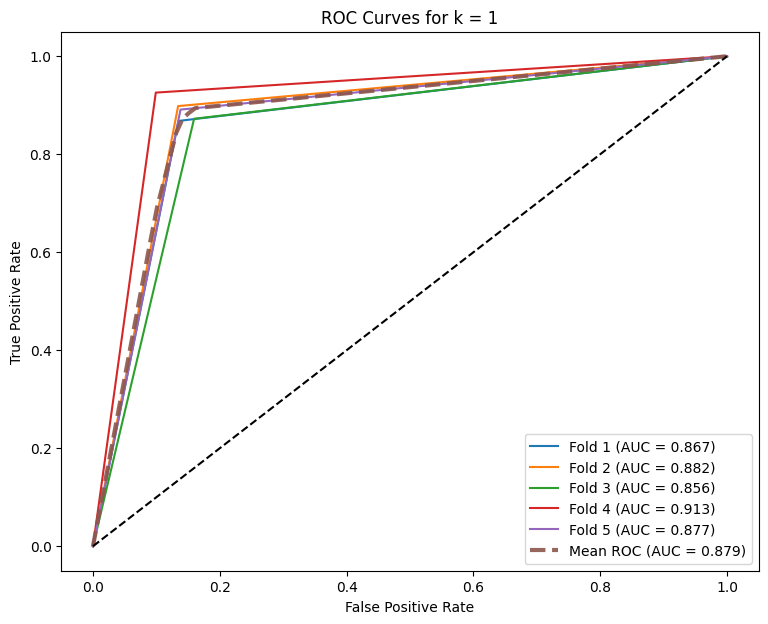

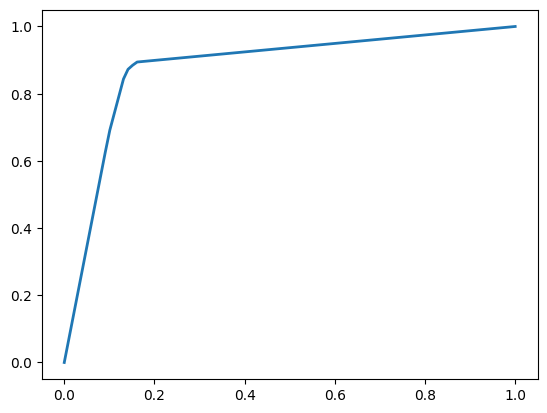

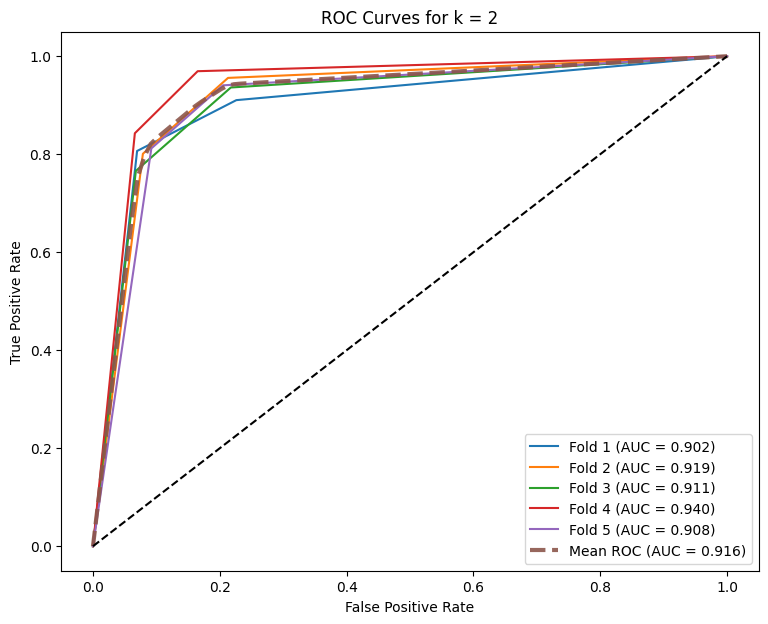

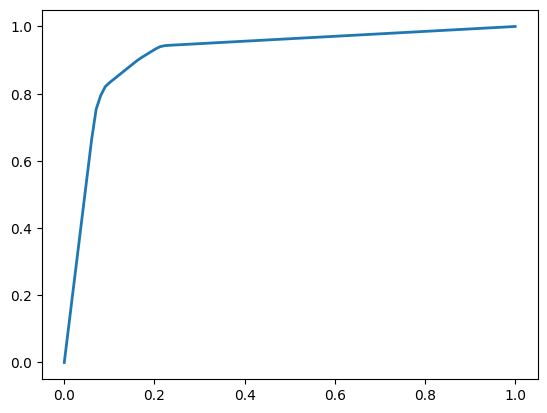

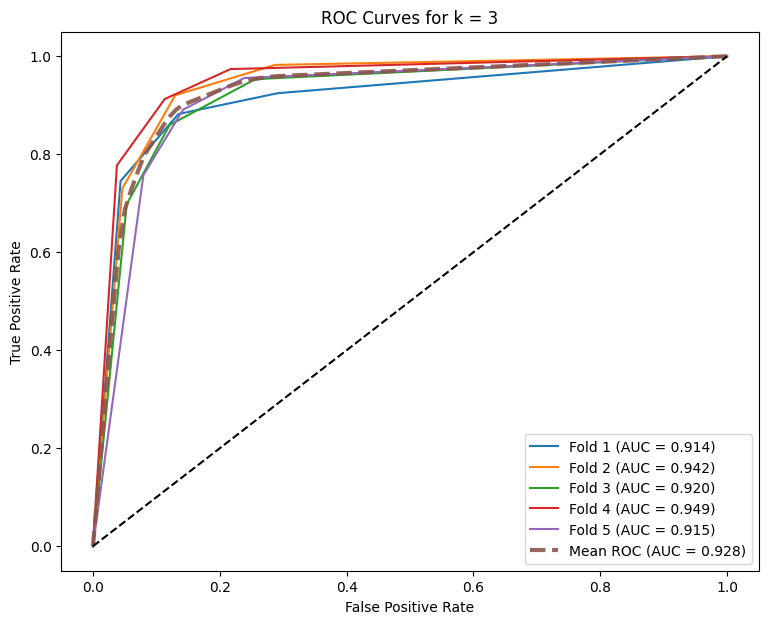

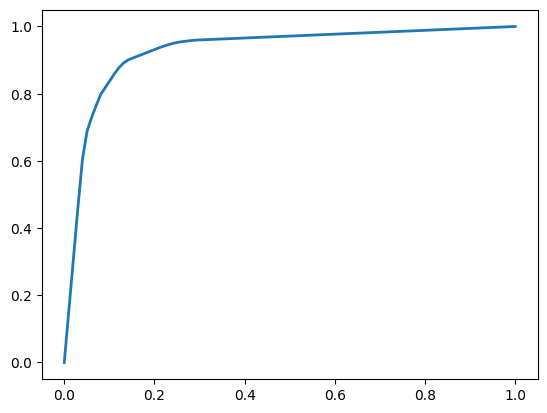

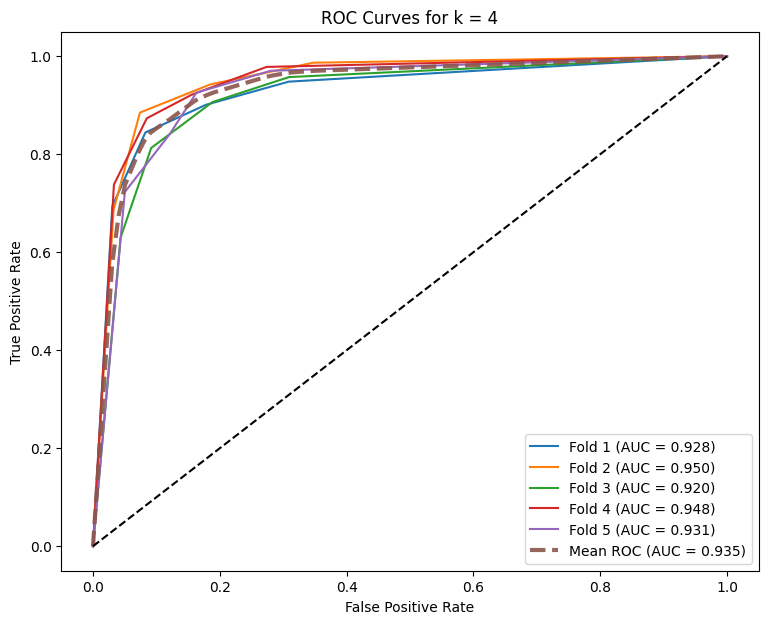

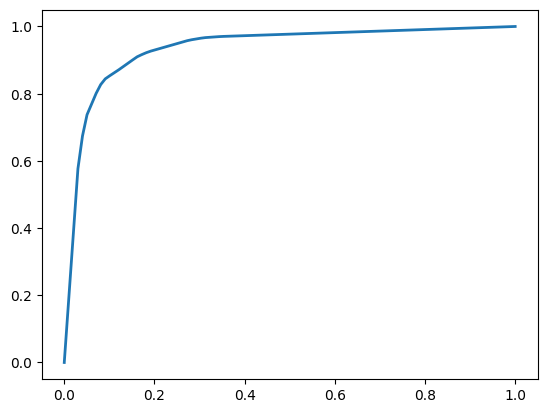

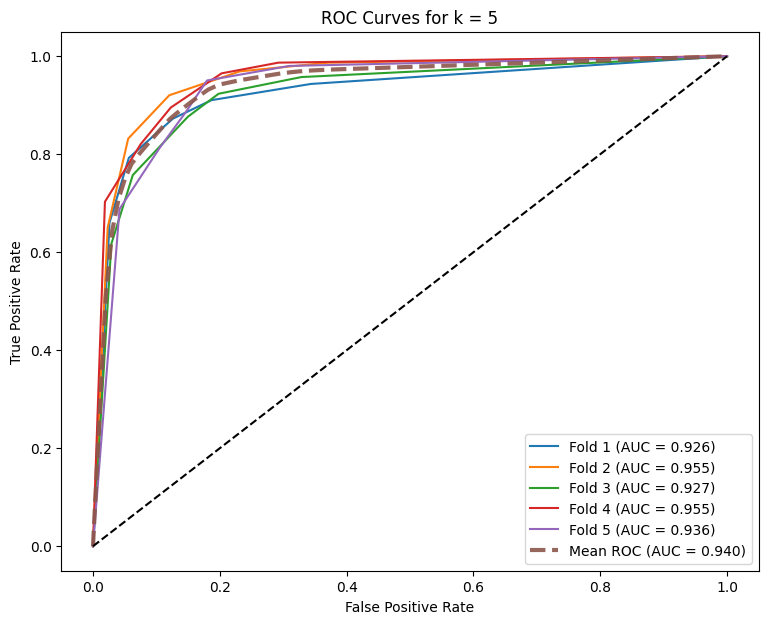

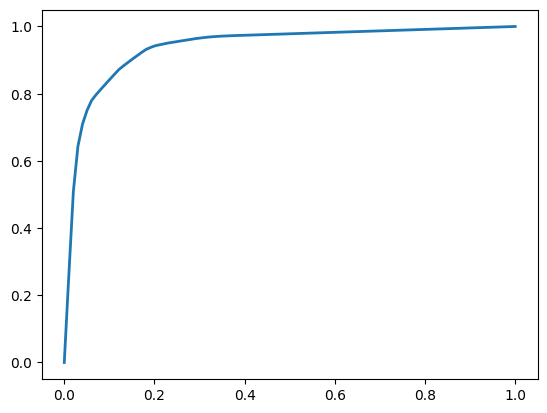

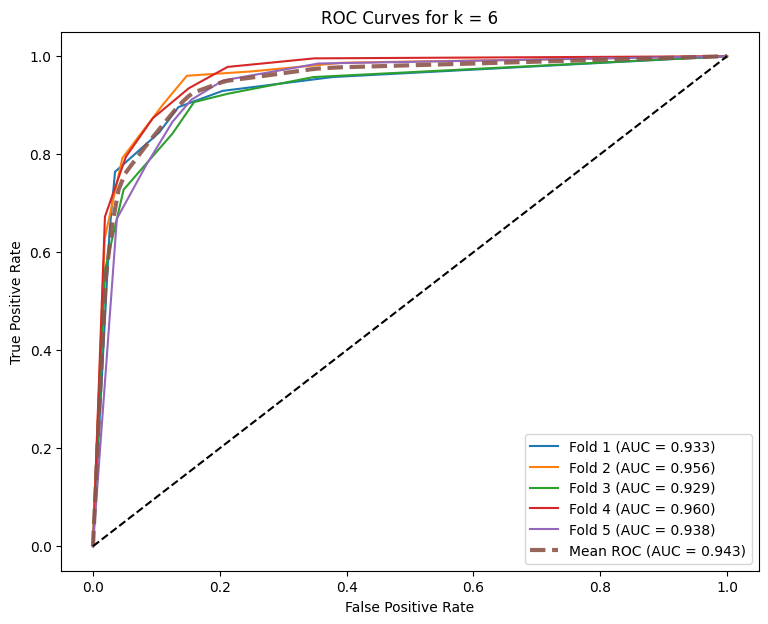

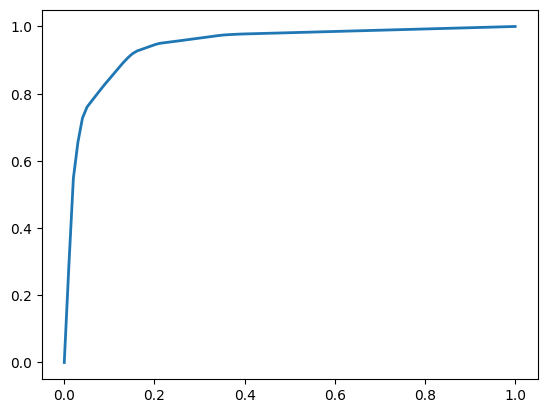

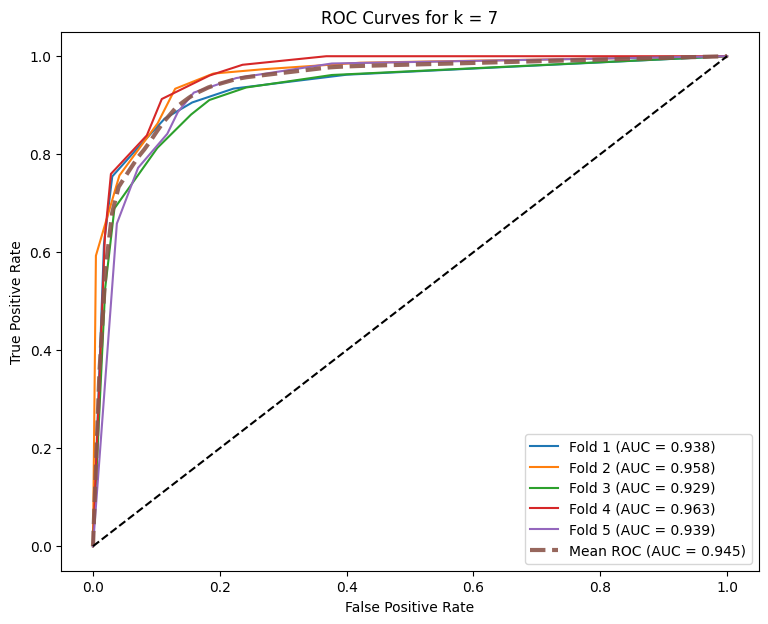

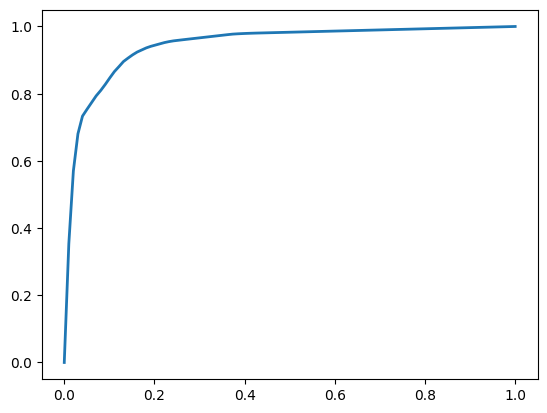

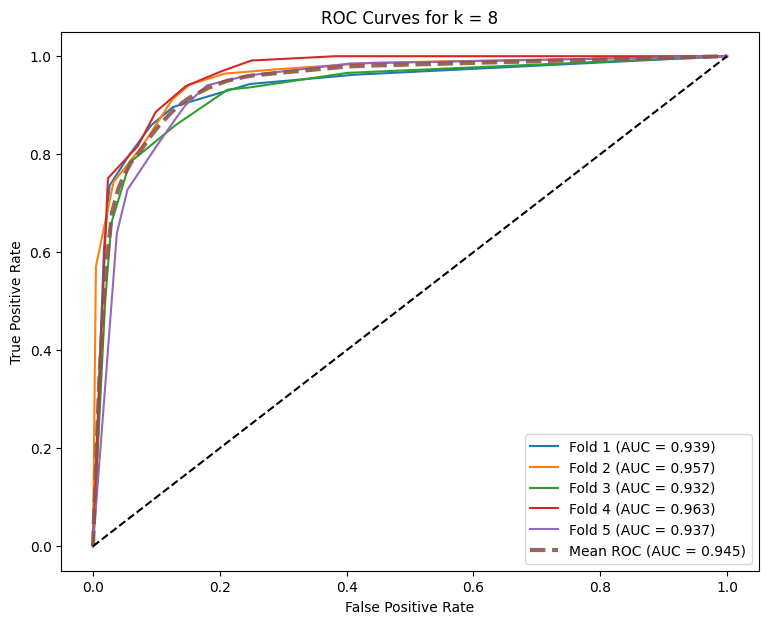

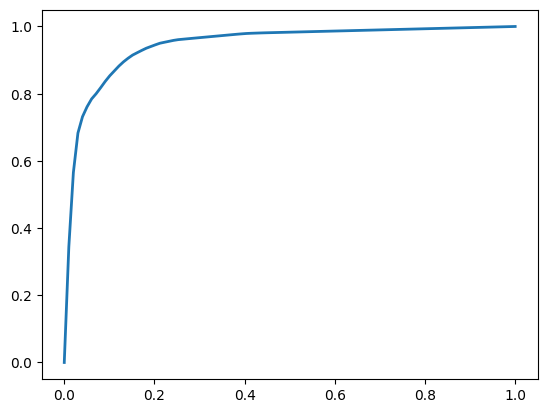

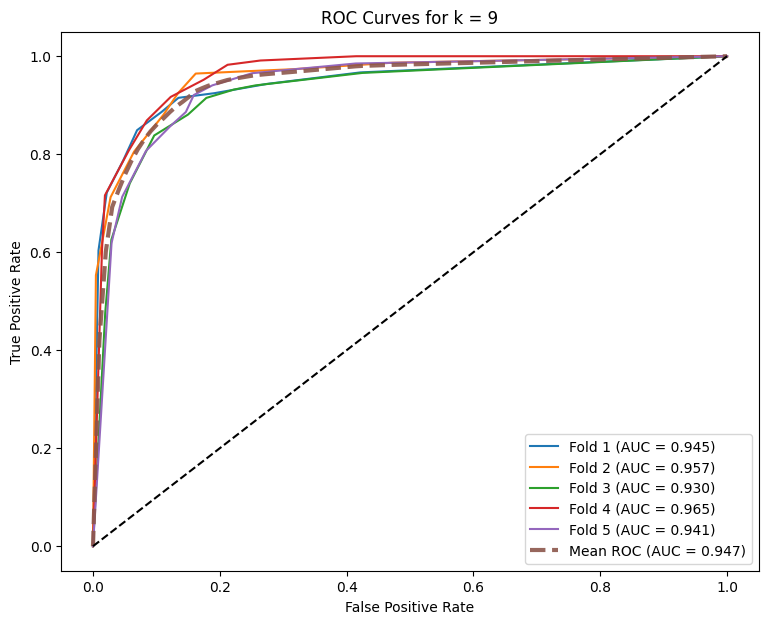

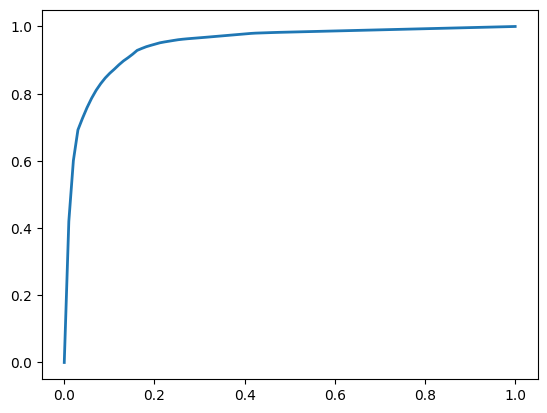

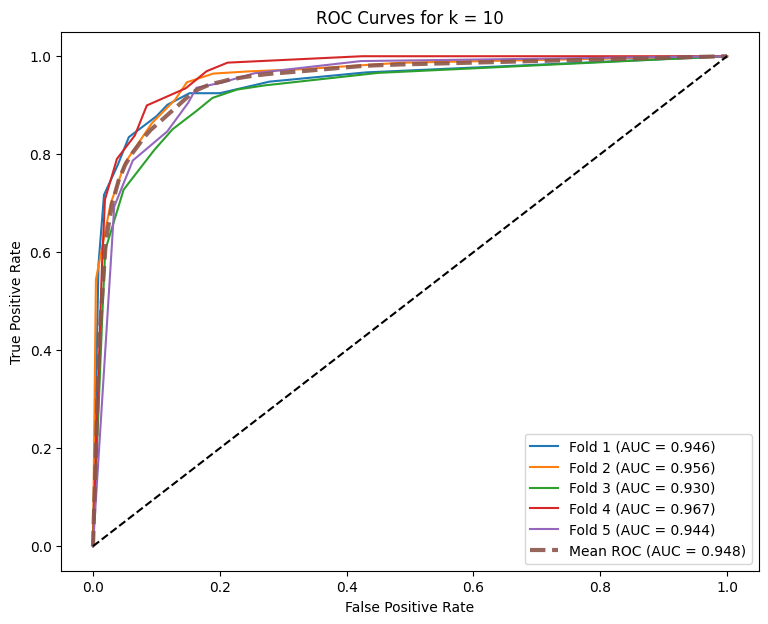

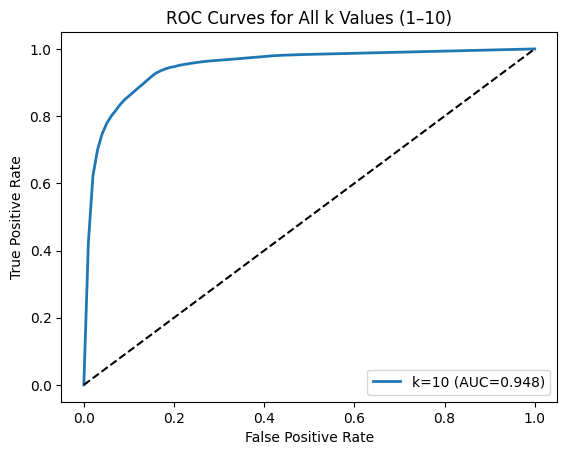



=== OVERALL PERFORMANCE ===
Confusion Matrix (pooled across all folds & k values):
[[9755. 1285.]
 [1374. 9666.]]
Overall Accuracy:   0.8796
Overall Sensitivity (TPR):  0.8755
Overall Specificity (TNR):  0.8836

=== RESULTS PER k ===
k= 1 | Acc=0.879 (±0.019) | AUC=0.879 | Sens=0.891 (±0.021) | Spec=0.867 (±0.019) | Runtime=1.263s
k= 2 | Acc=0.865 (±0.014) | AUC=0.916 | Sens=0.806 (±0.025) | Spec=0.925 (±0.010) | Runtime=1.438s
k= 3 | Acc=0.882 (±0.013) | AUC=0.928 | Sens=0.893 (±0.022) | Spec=0.872 (±0.010) | Runtime=1.004s
k= 4 | Acc=0.880 (±0.018) | AUC=0.935 | Sens=0.851 (±0.025) | Spec=0.909 (±0.016) | Runtime=0.751s
k= 5 | Acc=0.879 (±0.013) | AUC=0.940 | Sens=0.890 (±0.017) | Spec=0.867 (±0.012) | Runtime=0.825s
k= 6 | Acc=0.877 (±0.014) | AUC=0.943 | Sens=0.866 (±0.022) | Spec=0.888 (±0.012) | Runtime=0.830s
k= 7 | Acc=0.885 (±0.015) | AUC=0.945 | Sens=0.897 (±0.023) | Spec=0.872 (±0.016) | Runtime=0.668s
k= 8 | Acc=0.881 (±0.012) | AUC=0.945 | Sens=0.877 (±0.020) | Spec=0.88

In [ ]:
# ROC curves for 5-fold CV of KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import (
    roc_curve, auc, confusion_matrix, accuracy_score,
    classification_report
)
from sklearn.model_selection import KFold
import timeit


classes = np.unique(y)
if len(classes) != 2:
    raise ValueError("ROC curves require binary outcome. Your y has: ", classes)

pos_class = classes[1]
overall_conf_matrix = np.zeros((2, 2))
results_summary = []

plt.figure(figsize=(10, 8))

for k in range(1, 11):

    fold_tprs = []
    fold_aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    acc_scores = []

    sens_scores = []
    spec_scores = []

    start_time = timeit.default_timer()
    plt.figure(figsize=(9, 7))

    for fold, (train_idx, test_idx) in enumerate(cv.split(X), 1):

        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = neighbors.KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)[:, 1]

        cm = confusion_matrix(y_test, y_pred, labels=classes)
        overall_conf_matrix += cm

        tn, fp, fn, tp = cm.ravel()

        sens = tp / (tp + fn) if (tp + fn) > 0 else np.nan
        spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan

        sens_scores.append(sens)
        spec_scores.append(spec)

        acc = accuracy_score(y_test, y_pred)
        acc_scores.append(acc)

        fpr, tpr, _ = roc_curve(y_test, y_prob, pos_label=pos_class)
        roc_auc = auc(fpr, tpr)

        fold_tprs.append(np.interp(mean_fpr, fpr, tpr))
        fold_aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1.5, label=f"Fold {fold} (AUC = {roc_auc:.3f})")

    mean_tpr = np.mean(fold_tprs, axis=0)
    mean_auc = auc(mean_fpr, mean_tpr)

    plt.plot(
        mean_fpr,
        mean_tpr,
        lw=3,
        linestyle='--',
        label=f"Mean ROC (AUC = {mean_auc:.3f})",
        alpha=0.9
    )

    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f"ROC Curves for k = {k}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.show()

    elapsed = timeit.default_timer() - start_time

    mean_sens = np.nanmean(sens_scores)
    mean_spec = np.nanmean(spec_scores)
    std_sens = np.nanstd(sens_scores)
    std_spec = np.nanstd(spec_scores)

    results_summary.append({
        "k": k,
        "mean_accuracy": np.mean(acc_scores),
        "std_accuracy": np.std(acc_scores),
        "mean_auc": mean_auc,
        "mean_sensitivity": mean_sens,
        "std_sensitivity": std_sens,
        "mean_specificity": mean_spec,
        "std_specificity": std_spec,
        "runtime_sec": elapsed
    })

    plt.figure(1)
    plt.plot(mean_fpr, mean_tpr, lw=2, label=f"k={k} (AUC={mean_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curves for All k Values (1–10)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

TN, FP, FN, TP = overall_conf_matrix.ravel()
overall_accuracy = (TP + TN) / (TP + TN + FP + FN)
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

print("\n\n=== OVERALL PERFORMANCE ===")
print("Confusion Matrix (pooled across all folds & k values):")
print(overall_conf_matrix)
print(f"Overall Accuracy:   {overall_accuracy:.4f}")
print(f"Overall Sensitivity (TPR):  {sensitivity:.4f}")
print(f"Overall Specificity (TNR):  {specificity:.4f}")

print("\n=== RESULTS PER k ===")
for r in results_summary:
    print(
        f"k={r['k']:2d} | "
        f"Acc={r['mean_accuracy']:.3f} (±{r['std_accuracy']:.3f}) | "
        f"AUC={r['mean_auc']:.3f} | "
        f"Sens={r['mean_sensitivity']:.3f} (±{r['std_sensitivity']:.3f}) | "
        f"Spec={r['mean_specificity']:.3f} (±{r['std_specificity']:.3f}) | "
        f"Runtime={r['runtime_sec']:.3f}s"
    )
